# Parameter sensitivity analysis

Model optimised based on data from [Tsutsumi _et al._ 2011](https://doi.org/10.1038/nsmb.2125).


## Setup

In [1]:
#setup workspace
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from scipy.integrate import solve_ivp
import  model_utils as mu
import cma
import os
from tqdm import tqdm

In [2]:
#set up initial conditions
##initial concentrations (nM) as outlined in Tsutsumi et al.
pre_wt = 1
pre_sl = 1
wt_dcr = 0
sl_dcr = 0
wt_dcr_star = 0
sl_dcr_star = 0
dcr_wt = 5 #free Dicer in WT system
dcr_sl = 5 #free Dicer in SL system
wt = 0
sl = 0

init_values = [pre_wt, pre_sl, wt_dcr, sl_dcr, wt_dcr_star, sl_dcr_star, dcr_wt, dcr_sl, wt, sl]

##measured affinities for wt, sl pre-miRNAs (nM)
Kd_wt = 25.4
Kd_sl = 147.7

##initial theta (reaction rates) to be optimised:
ka_wt = 5
ka_sl = 5
kc_wt = .1
kc_sl = .1
kd = 5 

theta = np.log(np.array([ka_wt, ka_sl, kc_wt, kc_sl, kd, kd])) #log theta to prevent negative reaction rates in optimisation

#experimental data from figure 1, tsutsumi et al. to pass to optimiser
##extracted from graph
WT_data = np.array([0, 0.11144276160503169, 0.16566679779700877, 0.23905143587726366, 0.2954956726986665, 0.2946793863099961])
short_data = np.array([0, 0.0033684107002276975, 0.007599822974028003, 0.010019177812737812, 0.009603658536577298, 0.01242378048779691])
##simulation time and time steps
time = np.array([0, 5, 10, 20, 40, 60])
minutes = 60

### Functions

In [3]:
#model
def optim_model(t, init_values, ka1, ka2, kc1, kc2, kd1, kd2):
    """
    Model for optimising parameters for expanded model. Using short loop and wt maturing 
    miRNAs in separate Dicer pool.
    """   
    kb1 = ka2 * Kd_wt #Kd = kb / ka
    kb2 = ka2 * Kd_sl
    
    init_pMiR1, init_pMiR2, init_pMiR1_dcr, init_pMiR2_dcr, init_pMiR1_dcr_star, \
    init_pMiR2_dcr_star, init_dcr1, init_dcr2, init_miR1, init_miR2 = init_values
    
    pMiR1 = init_pMiR1_dcr * kb1 - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    pMiR1_dcr = init_pMiR1 * init_dcr1 * ka1 - init_pMiR1_dcr * (kb1 + kd)
    pMiR1_dcr_star = init_pMiR1 * init_dcr1 * kc1
    dcr1 = init_pMiR1_dcr * (kb1 + kd) - init_pMiR1 * init_dcr1 * (ka1 + kc1)
    MiR1 = init_pMiR1_dcr * kd1
    
    pMiR2 = init_pMiR2_dcr * kb2 - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    pMiR2_dcr = init_pMiR2 * init_dcr2 * ka2 - init_pMiR2_dcr * (kb2 + kd)
    pMiR2_dcr_star = init_pMiR2 * init_dcr2 * kc2
    dcr2 = init_pMiR2_dcr * (kb2 + kd) - init_pMiR2 * init_dcr2 * (ka2 + kc2)
    MiR2 = init_pMiR2_dcr * kd2

    
    return pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2
    

In [4]:
#calculate fraction diced
def frac_diced(theta):
    """
    Function to calculate the fraction of WT, short loop miRNAs diced
    """
    ka1, ka2, kc1, kc2, kd1, kd2 = np.exp(theta)
        
    sol = solve_ivp(optim_model, (0, int(minutes)), init_values, \
                    method = 'LSODA', args = (ka1, ka2, kc1, kc2, kd1, kd2))
    
    pMiR1, pMiR2, pMiR1_dcr, pMiR2_dcr, pMiR1_dcr_star, pMiR2_dcr_star, dcr1, dcr2, MiR1, MiR2 = sol.y
    
    diced1 = []
    diced2 = []
    
    for i in range(len(MiR1)):
        diced1.append(MiR1[i]/ pMiR1[0]) #1 pMiR = 1 MiR
        diced2.append(MiR2[i] / pMiR2[0]) #using pMiR and MiR to account for loss of pMiR
                                                      #in pMiR_dcr_star
                      
    return diced1, diced2, sol.t

In [5]:
#create error function
def errorODE(theta):
    """
    Function to calculate the relative error of ODE model values against data values.
    """
    
    diced1, diced2, ts = frac_diced(theta)
    
    data = np.array([[WT_data],
                     [short_data*10]])#scale by 10 to force optimisation to account for relative changes
    WT = np.interp(time, ts, diced1)
    short = np.interp(time, ts, diced2)

    
    model = np.array([[WT],
                      [short*10]])#scale by 10 to force optimisation to account for relative changes
    
    return np.sum(np.power((data-model), 2))
    

## Optimisation

In [7]:
#minimise with CMA-ES
##NB! Optimised values vary between optimisation runs!
##Run optimisation 100 times
results = []
ix = ['fmin', 'log ka_wt', 'log ka_short', 'log kc_wt', 'log kc_short', 'log kd_wt', 'log kd_short']
for i in tqdm(range(100)):
    res = cma.fmin(errorODE, theta, 2)
    results.append([res[1], res[0][:]])
    os.renames('outcmaes', 'outcmaes' + str(i))


  0%|          | 0/100 [00:00<?, ?it/s]

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=424648, Thu Nov 30 10:55:36 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.129445809074710e-01 1.0e+00 1.89e+00  2e+00  2e+00 0:00.1
    2     18 6.667911964570791e-02 1.3e+00 1.92e+00  2e+00  2e+00 0:00.1
    3     27 1.431685520074765e-01 1.4e+00 1.69e+00  1e+00  2e+00 0:00.2
   78    702 3.917622433810503e-03 2.9e+01 5.13e-01  1e-01  6e-01 0:03.2
  100    900 1.798471410666538e-03 2.8e+01 6.33e-01  1e-01  5e-01 0:03.9
  200   1800 1.258850894042968e-03 4.7e+02 2.62e-01  3e-03  4e-01 0:06.9
  300   2700 1.250556315492066e-03 1.5e+03 9.87e-01  2e-03  8e-01 0:10.0
  400   3600 1.247980908417298e-03 7.1e+03 6.53e-02  3e-05  4e-02 0:13.2
  500   4500 1.247981075254666e-03 2.1e+04 3.39e-02  6e-06  2e-02 0:16.4
  600   5400 1.247980700259158e-03 1.1e+05 2.83e-02  4e-06  1e-02 0:19.3
  700   6300 1.247981148970000e-03 2.9e+05 3.33e-02  2e-06  5e-03 0:22.0
  800   7200 1.247980588413804e-03 

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.3e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=898)
  warnings.warn(msg + ' (' +


 1000   9000 1.247980182766422e-03 1.7e+01 1.75e-02  9e-03  2e-02 0:30.4
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1090   9810 1.247980813984632e-03 2.1e+01 1.22e-02  3e-03  7e-03 0:33.1


  1%|          | 1/100 [00:37<1:01:04, 37.02s/it]

termination on tolstagnation=256 (Thu Nov 30 10:56:13 2023)
final/bestever f-value = 1.247981e-03 1.247980e-03
incumbent solution: [3.678112229843933, 6.7266518631922665, -4.810566070918819, -20.35395175901408, 1.034793601589973, -2.973654482817971]
std deviation: [0.007215140192046046, 0.004293061632495387, 0.00289464515096931, 0.005371741071789839, 0.004217091856887836, 0.004273497935081697]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=498978, Thu Nov 30 10:56:13 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.231104187302201e-01 1.0e+00 1.86e+00  2e+00  2e+00 0:00.0
    2     18 1.382786129834876e-01 1.2e+00 1.77e+00  2e+00  2e+00 0:00.1
    3     27 3.480714940659056e-02 1.3e+00 1.69e+00  2e+00  2e+00 0:00.1
   65    585 3.096960867439589e-02 7.1e+01 6.00e-02  2e-03  1e-01 0:03.2
  100    900 3.096955940457833e-02 6.0e+02 1.98e-02  2e-04  5e-02 0:04.7
  200   1800 3.096953554359000e-02 1.2e+03 1.68e-03  6e-06  1e-03 0:09.2
  3

  2%|▏         | 2/100 [00:58<45:52, 28.08s/it]  

termination on tolfun=1e-11 (Thu Nov 30 10:56:35 2023)
final/bestever f-value = 3.096953e-02 3.096953e-02
incumbent solution: [6.734471292737379, 0.21332831798915036, -0.2879520203266449, 1.8326949024553358, 0.10752994875916523, 2.104464382679814]
std deviation: [3.281966260696159e-05, 2.7673390043353136e-05, 9.951672165800092e-05, 9.382433211664005e-06, 6.439682137643611e-07, 9.914039610276092e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=501606, Thu Nov 30 10:56:35 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.337562151576991e+00 1.0e+00 1.82e+00  2e+00  2e+00 0:00.0
    2     18 6.539599916073018e-02 1.2e+00 1.98e+00  2e+00  2e+00 0:00.1
    3     27 5.879377798917521e-02 1.4e+00 2.26e+00  2e+00  3e+00 0:00.1
   99    891 1.244507690862850e-03 1.1e+02 2.70e-02  2e-03  3e-02 0:03.1
  100    900 1.243962309949361e-03 1.0e+02 2.65e-02  2e-03  3e-02 0:03.2
  200   1800 1.243219966456442e-03 2.3e+03 3.25e-02  4e-04  3e-01 0:06

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=585)
  warnings.warn(msg + ' (' +


  600   5400 1.243130364133756e-03 2.1e+00 1.97e-04  2e-04  2e-04 0:18.0
  700   6300 1.243126131744541e-03 2.6e+01 1.09e-04  3e-05  2e-04 0:21.1
  800   7200 1.243131669947425e-03 4.5e+01 1.11e-05  9e-07  6e-06 0:24.0
  840   7560 1.243130198978065e-03 6.4e+01 1.91e-05  1e-06  1e-05 0:25.2


  3%|▎         | 3/100 [01:26<45:18, 28.02s/it]

termination on tolstagnation=256 (Thu Nov 30 10:57:03 2023)
final/bestever f-value = 1.243128e-03 1.243122e-03
incumbent solution: [4.585891853491617, 8.061123482832187, -4.464638668010707, -16.868757560934426, 1.4703517843305676, -2.9736721902797427]
std deviation: [5.284138195220194e-06, 5.820516603383106e-06, 1.1588392346108822e-05, 1.1560948477577687e-06, 3.4178735643026213e-06, 4.198060081154599e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=424378, Thu Nov 30 10:57:03 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.020434248942880e+00 1.0e+00 1.80e+00  2e+00  2e+00 0:00.0
    2     18 4.659800915150395e-01 1.2e+00 1.66e+00  2e+00  2e+00 0:00.1
    3     27 1.821752096937375e-01 1.4e+00 1.85e+00  2e+00  2e+00 0:00.1
  100    900 4.798880890553961e-03 3.6e+01 2.52e-01  1e-02  2e-01 0:02.9
  200   1800 4.785989317418981e-03 2.9e+02 4.02e-03  2e-04  6e-03 0:04.9
  300   2700 4.783447187004184e-03 1.2e+02 8.22e-02  7e-04  2e-0

  4%|▍         | 4/100 [01:49<41:27, 25.91s/it]

termination on tolfun=1e-11 (Thu Nov 30 10:57:26 2023)
final/bestever f-value = 4.783319e-03 4.783319e-03
incumbent solution: [-4.014999271476509, -3.8516520003066295, -6.790160921601831, 0.23527866294191935, 0.4690275364324392, 1.438057876088676]
std deviation: [5.183553112475704e-07, 7.551110866050207e-08, 2.268580490938104e-06, 3.3192995004677704e-09, 2.1817590699554219e-07, 4.827084626381835e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=466123, Thu Nov 30 10:57:26 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.643992170806227e-01 1.0e+00 2.12e+00  2e+00  2e+00 0:00.0
    2     18 1.531162356590157e-01 1.4e+00 2.08e+00  2e+00  2e+00 0:00.1
    3     27 6.978084289462270e-02 1.4e+00 2.10e+00  2e+00  2e+00 0:00.1
  100    900 6.894310021402869e-04 3.8e+01 2.32e-01  1e-02  2e-01 0:02.4
  200   1800 6.631254788340011e-04 1.4e+02 1.22e-01  2e-03  7e-02 0:04.0
  300   2700 6.593663401375412e-04 1.1e+03 6.10e-02  7e-04  6e-02 0:0

  5%|▌         | 5/100 [02:03<34:09, 21.58s/it]

termination on tolfun=1e-11 (Thu Nov 30 10:57:40 2023)
final/bestever f-value = 6.434421e-04 6.434421e-04
incumbent solution: [-4.912381665946875, -3.152815497864371, -4.433086664211839, -74.59509109717887, 1.4947267742787405, -2.8627916523810573]
std deviation: [2.5041681076011303e-05, 5.05338387503384e-06, 1.1543136283306376e-05, 0.006037896812228586, 2.365548670956928e-05, 1.2850359928178026e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=388196, Thu Nov 30 10:57:40 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.921595125086622e-02 1.0e+00 1.91e+00  2e+00  2e+00 0:00.0
    2     18 9.636108907193892e-02 1.2e+00 1.73e+00  2e+00  2e+00 0:00.1
    3     27 1.835935325739093e-01 1.3e+00 1.52e+00  1e+00  2e+00 0:00.1
   94    846 1.426144772435507e-03 4.0e+01 2.34e-01  1e-02  2e-01 0:03.1
  100    900 1.382088918534456e-03 6.3e+01 2.71e-01  1e-02  3e-01 0:03.3
  200   1800 1.265379189449368e-03 2.6e+03 1.38e-01  3e-04  4e-01 0:05

  6%|▌         | 6/100 [02:31<37:16, 23.79s/it]

termination on tolstagnation=256 (Thu Nov 30 10:58:08 2023)
final/bestever f-value = 1.264834e-03 1.264833e-03
incumbent solution: [3.704440627062824, 6.157291595067871, -8.245684844446261, -284.69406610687764, 0.4187216695043636, -2.9736681002947414]
std deviation: [5.6572549925322334e-05, 5.6439784667918456e-05, 0.00019724745815682433, 0.10659398927777947, 2.990617187602952e-06, 5.866214476461611e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=388107, Thu Nov 30 10:58:08 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.348329469723174e-01 1.0e+00 1.85e+00  2e+00  2e+00 0:00.0
    2     18 5.477861488977634e-02 1.2e+00 1.84e+00  2e+00  2e+00 0:00.1
    3     27 1.270720243963591e-01 1.2e+00 2.12e+00  2e+00  2e+00 0:00.1
   86    774 2.685313446190595e-02 7.9e+01 1.09e-01  2e-02  2e-01 0:03.1
  100    900 2.684932740723458e-02 1.3e+02 6.28e-02  9e-03  1e-01 0:03.6
  200   1800 2.684786856446278e-02 2.7e+02 3.10e-02  2e-03  2e-02 

  7%|▋         | 7/100 [02:53<35:45, 23.07s/it]

termination on tolfun=1e-11 (Thu Nov 30 10:58:29 2023)
final/bestever f-value = 2.684712e-02 2.684701e-02
incumbent solution: [1.5450177192361656, -3.4374473349164556, -0.06407253833652554, -5.929135431152585, 0.3102951948405261, -2.7142245376338185]
std deviation: [3.31156054715203e-07, 1.3695187399906735e-06, 2.5658073213115716e-06, 1.6062786523883044e-05, 6.033685349562425e-07, 1.7093847930327307e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=484278, Thu Nov 30 10:58:29 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 7.427191488631070e+00 1.0e+00 1.95e+00  2e+00  2e+00 0:00.0
    2     18 2.649965871947229e-01 1.2e+00 2.25e+00  2e+00  2e+00 0:00.1
    3     27 5.487617592247943e-02 1.4e+00 2.16e+00  2e+00  2e+00 0:00.1
  100    900 6.773012735173087e-04 5.6e+01 8.34e-02  1e-02  1e-01 0:02.2
  200   1800 6.656317073539395e-04 7.5e+01 1.23e-01  1e-02  5e-02 0:03.8
  300   2700 6.595754235959799e-04 6.1e+01 2.65e-01  5e-03  3e-02

  8%|▊         | 8/100 [03:09<31:58, 20.86s/it]

termination on tolfunhist=1e-12 (Thu Nov 30 10:58:45 2023)
final/bestever f-value = 6.401051e-04 6.401051e-04
incumbent solution: [-5.914830410090422, -3.543963544511568, -4.149902505855452, -5.616834824693095, 2.4510051089838836, -2.6536943419259806]
std deviation: [5.634786057980875e-06, 3.2617729761026804e-07, 4.250119976271023e-08, 8.748423631174545e-06, 5.058742368636319e-06, 1.4721931230325968e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=438811, Thu Nov 30 10:58:45 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.008159795116554e-01 1.0e+00 1.85e+00  2e+00  2e+00 0:00.0
    2     18 3.862742595511510e-01 1.2e+00 1.72e+00  2e+00  2e+00 0:00.1
    3     27 5.566035466994357e-02 1.3e+00 1.80e+00  2e+00  2e+00 0:00.1
  100    900 1.194306264432417e-03 2.1e+02 3.73e-01  7e-03  1e+00 0:02.6
  200   1800 6.737333799956776e-04 3.5e+03 3.40e-02  8e-05  2e-01 0:04.4
NOTE (module=cma, iteration=239):  
condition in coordinate syste

  9%|▉         | 9/100 [03:15<24:33, 16.19s/it]

termination on tolfun=1e-11 (Thu Nov 30 10:58:51 2023)
final/bestever f-value = 6.737320e-04 6.737320e-04
incumbent solution: [-3.8542971979349767, -3.1181038397747347, -26.842740994627423, -17.930986667348765, 0.4017131648624419, -2.865994863605621]
std deviation: [1.6579880060631621e-06, 4.97462839511202e-06, 0.0047323136378829905, 0.0009128618715890885, 2.8836561386547143e-07, 7.121228804366168e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=473884, Thu Nov 30 10:58:51 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.947256617714597e-01 1.0e+00 2.04e+00  2e+00  2e+00 0:00.0
    2     18 7.313841525382170e-02 1.3e+00 2.35e+00  2e+00  3e+00 0:00.1
    3     27 7.261516509285465e-02 1.6e+00 2.31e+00  2e+00  3e+00 0:00.1
   97    873 1.350870633266220e-03 2.5e+01 2.53e-01  3e-02  2e-01 0:03.1
  100    900 1.297589629858797e-03 2.6e+01 2.10e-01  2e-02  1e-01 0:03.2
  200   1800 1.241495442840148e-03 2.4e+03 6.58e-02  3e-04  2e-01 0

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=534)
  warnings.warn(msg + ' (' +


  600   5400 1.241168424367941e-03 1.0e+01 6.27e-03  3e-03  7e-03 0:17.6
  700   6300 1.241168498994666e-03 3.9e+01 2.47e-03  8e-04  2e-03 0:20.5
  775   6975 1.241168915078654e-03 4.7e+01 3.22e-03  4e-04  2e-03 0:22.8


 10%|█         | 10/100 [03:40<28:28, 18.99s/it]

termination on tolstagnation=256 (Thu Nov 30 10:59:17 2023)
final/bestever f-value = 1.241169e-03 1.241168e-03
incumbent solution: [-0.3876341797624754, 2.8316159126800233, -4.629043206887623, -17.49898999804894, 1.2214494404337337, -2.9732878249234957]
std deviation: [0.001746192378216886, 0.00038514067048001945, 0.0014388384708782316, 0.001182065753333019, 0.0007467859791027351, 0.0017936543031266236]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=387043, Thu Nov 30 10:59:17 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.594439988359878e+00 1.0e+00 1.87e+00  2e+00  2e+00 0:00.0
    2     18 1.276452270233701e+00 1.2e+00 1.93e+00  2e+00  2e+00 0:00.1
    3     27 8.876718028340641e-02 1.3e+00 2.25e+00  2e+00  2e+00 0:00.1
   92    828 6.797510652402815e-02 2.4e+03 1.62e-01  2e-04  2e-01 0:03.1
  100    900 6.797510673112038e-02 5.1e+03 1.48e-01  2e-04  2e-01 0:03.4
  200   1800 6.797510593986829e-02 1.1e+05 7.71e-02  3e-05  1e-01 

 11%|█         | 11/100 [04:04<30:39, 20.67s/it]

termination on tolstagnation=256 (Thu Nov 30 10:59:41 2023)
final/bestever f-value = 2.684806e-02 2.684801e-02
incumbent solution: [17.484072651721007, -3.6796216541642073, 9.349392865995771, -5.34742226121373, 0.10086669741588124, -2.5770022420085574]
std deviation: [0.0013958022644737847, 0.00031042161493070425, 0.007545727541022018, 0.005443754817089571, 5.2813065909810845e-06, 0.0009646853979503972]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=424703, Thu Nov 30 10:59:41 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.479773162315428e-01 1.0e+00 2.12e+00  2e+00  2e+00 0:00.0
    2     18 5.061016835195881e-02 1.3e+00 1.97e+00  2e+00  2e+00 0:00.1
    3     27 6.413585682045833e-02 1.4e+00 1.92e+00  2e+00  2e+00 0:00.1
   89    801 2.746751027351156e-02 1.8e+02 1.33e-01  5e-03  3e-01 0:03.1
  100    900 2.747012636045391e-02 3.9e+02 1.54e-01  4e-03  5e-01 0:03.6
  200   1800 2.746490745671755e-02 1.9e+02 2.07e-02  2e-04  1e-02 

 12%|█▏        | 12/100 [04:29<31:55, 21.76s/it]

termination on tolstagnation=256 (Thu Nov 30 11:00:05 2023)
final/bestever f-value = 2.746353e-02 2.746353e-02
incumbent solution: [9.43473296116746, 6.677855351884746, -1.07322081335843, -17.952702697232496, 0.20570290415297862, -2.973648299961183]
std deviation: [1.7013105251470967e-06, 1.750804226024299e-06, 5.936678845818514e-07, 0.0003234778628888624, 5.35342420911104e-08, 1.2008815545577563e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=496495, Thu Nov 30 11:00:05 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.672658585860158e-01 1.0e+00 2.05e+00  2e+00  2e+00 0:00.0
    2     18 2.207341394385385e-01 1.4e+00 2.04e+00  2e+00  2e+00 0:00.1
    3     27 8.889618022671592e-02 1.4e+00 2.21e+00  2e+00  2e+00 0:00.1
   88    792 4.752708470986909e-03 1.5e+02 8.81e-02  2e-02  2e-01 0:03.1
  100    900 4.751098814247845e-03 2.5e+02 4.80e-02  9e-03  1e-01 0:03.5
  200   1800 4.749039385593014e-03 2.2e+02 9.31e-03  6e-04  5e-03 0:

 13%|█▎        | 13/100 [04:48<30:43, 21.19s/it]

termination on tolstagnation=256 (Thu Nov 30 11:00:25 2023)
final/bestever f-value = 4.749161e-03 4.748274e-03
incumbent solution: [-0.005147945258386331, 2.868908309526788, -5.05310591330782, 1.6399980202752251, 0.8653893466856528, 1.8879869493735655]
std deviation: [9.24722814398187e-06, 7.775524159259127e-06, 1.6589147149676355e-06, 3.073709869282386e-06, 9.77519806232612e-06, 5.633259085514096e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=485154, Thu Nov 30 11:00:25 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.820196763318306e-01 1.0e+00 2.16e+00  2e+00  2e+00 0:00.0
    2     18 2.787313943081065e-01 1.4e+00 2.44e+00  2e+00  3e+00 0:00.1
    3     27 1.714325481942794e-01 1.6e+00 2.43e+00  2e+00  3e+00 0:00.1
   97    873 2.731658428351961e-02 9.5e+01 2.24e-01  2e-02  3e-01 0:03.1
  100    900 2.730742336176328e-02 1.2e+02 1.85e-01  1e-02  2e-01 0:03.2
  200   1800 2.280824663750187e-03 3.5e+02 3.10e+00  6e-02  3e+00 0

 14%|█▍        | 14/100 [05:00<26:16, 18.33s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:00:37 2023)
final/bestever f-value = 6.372591e-04 6.372591e-04
incumbent solution: [-38.24751924346248, -3.084467398955811, -4.0074681809943975, -20.176419483785587, 34.86076409871078, -2.8694698942202193]
std deviation: [0.003302422932916875, 2.407611334131217e-06, 2.921447761998466e-06, 0.06664031703318979, 0.0033009329461609616, 1.3410830136137212e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=437311, Thu Nov 30 11:00:37 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.634718458537089e-01 1.0e+00 1.90e+00  2e+00  2e+00 0:00.0
    2     18 2.006252333234065e-01 1.3e+00 1.87e+00  2e+00  2e+00 0:00.1
    3     27 2.168529801369250e-01 1.4e+00 1.71e+00  1e+00  2e+00 0:00.1
  100    900 3.096954487236898e-02 2.9e+02 9.43e-03  5e-03  9e-03 0:03.1
  200   1800 3.096955516280195e-02 1.0e+03 5.54e-03  2e-03  4e-03 0:06.2
  300   2700 3.096954640106104e-02 1.2e+03 2.23e-03  3e-04  8e-04 0:09.3

 15%|█▌        | 15/100 [05:21<27:00, 19.06s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:00:58 2023)
final/bestever f-value = 3.096955e-02 2.470452e-02
incumbent solution: [0.15015942516070946, 0.07676565750265375, -0.05771163018592784, 0.4418907020119255, 1.9365293795813388, 0.7331785116593137]
std deviation: [2.474649064753438e-05, 1.7556695252388754e-05, 2.4487137905995716e-05, 1.7420618329723577e-05, 2.0731262985244962e-05, 1.6507083646677343e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=427817, Thu Nov 30 11:00:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.865707995651993e-01 1.0e+00 1.84e+00  2e+00  2e+00 0:00.0
    2     18 2.983024911492225e-01 1.2e+00 2.01e+00  2e+00  2e+00 0:00.1
    3     27 1.599494011204169e-01 1.4e+00 2.17e+00  2e+00  2e+00 0:00.1
  100    900 1.242405343089769e-03 1.8e+02 1.21e-01  7e-03  2e-01 0:02.8
  200   1800 1.235656713237615e-03 5.6e+03 1.28e-02  7e-05  7e-02 0:05.3
NOTE (module=cma, iteration=263):  
condition in coordinate sys

 16%|█▌        | 16/100 [05:36<24:53, 17.78s/it]

termination on tolstagnation=256 (Thu Nov 30 11:01:13 2023)
final/bestever f-value = 1.235642e-03 1.235642e-03
incumbent solution: [-0.41323047107945343, 5.570235581905185, -4.055985749598655, -20.39270543061509, 3.9948816070851443, -2.9735851395519264]
std deviation: [1.8856303712510537e-06, 7.649137419260884e-07, 6.157717637365289e-07, 0.0038751229702046774, 1.8942836136426557e-06, 3.190753687402873e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=439987, Thu Nov 30 11:01:13 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.822107882073492e-01 1.0e+00 2.02e+00  2e+00  2e+00 0:00.0
    2     18 1.449916188913875e-01 1.4e+00 2.16e+00  2e+00  2e+00 0:00.1
    3     27 8.544833159644442e-02 1.3e+00 2.29e+00  2e+00  2e+00 0:00.1
   81    729 2.685489740771115e-02 5.6e+01 2.51e-01  8e-03  4e-01 0:03.1
  100    900 2.685037075780354e-02 1.0e+02 9.41e-02  1e-03  1e-01 0:03.8
  200   1800 2.684988758222722e-02 8.0e+02 5.65e-02  4e-04  1e-

 17%|█▋        | 17/100 [06:16<34:02, 24.61s/it]

termination on tolstagnation=256 (Thu Nov 30 11:01:53 2023)
final/bestever f-value = 2.684884e-02 2.684826e-02
incumbent solution: [11.867386994103779, -4.343309263893619, -14.40551709314672, -4.5941597187648044, 0.101065437435064, -2.1293455804477777]
std deviation: [1.1252539466451635e-06, 1.1213738136490224e-07, 6.0797380600510696e-05, 1.826250974341475e-06, 5.573704032910953e-07, 1.175127000471889e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=396878, Thu Nov 30 11:01:53 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.414876004006838e-01 1.0e+00 2.12e+00  2e+00  2e+00 0:00.0
    2     18 5.328389950083299e-02 1.3e+00 2.19e+00  2e+00  2e+00 0:00.1
    3     27 6.419885832265142e-02 1.5e+00 2.19e+00  2e+00  2e+00 0:00.1
   75    675 3.097231386296405e-02 9.4e+01 4.46e-01  2e-02  8e-01 0:03.2
  100    900 3.096980703885797e-02 4.7e+02 2.77e-01  2e-03  6e-01 0:04.5
  193   1737 3.096954754177155e-02 1.9e+03 1.41e-02  1e-05  1e-

 18%|█▊        | 18/100 [06:52<38:13, 27.97s/it]

termination on tolstagnation=256 (Thu Nov 30 11:02:29 2023)
final/bestever f-value = 3.096955e-02 3.096954e-02
incumbent solution: [17.931634892899204, 5.686662606587978, -11.226139770551523, 6.5133291133194025, 0.1010525538135696, 6.753027756135361]
std deviation: [6.594646216940265e-05, 0.00019219903339452347, 5.0609878990278224e-05, 5.2056241457864165e-05, 1.9831143072184021e-07, 5.244344519899528e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=390785, Thu Nov 30 11:02:29 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.432839839109802e-01 1.0e+00 1.82e+00  2e+00  2e+00 0:00.0
    2     18 2.384922344333749e-01 1.3e+00 1.82e+00  2e+00  2e+00 0:00.1
    3     27 1.604606888917488e-01 1.4e+00 1.80e+00  2e+00  2e+00 0:00.1
   66    594 3.097116815921009e-02 6.5e+01 4.04e-01  1e-02  6e-01 0:03.1
  100    900 3.096957223381167e-02 7.4e+02 6.74e-02  3e-04  2e-01 0:04.8
NOTE (module=cma, iteration=165):  
condition in coordinate syst

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=606)
  warnings.warn(msg + ' (' +


  700   6300 3.096954162263215e-02 1.4e+01 2.22e-04  1e-04  3e-04 0:34.4
  800   7200 3.096954166474673e-02 7.7e+01 4.07e-05  7e-06  5e-05 0:39.3
  830   7470 3.096954166289714e-02 8.3e+01 4.63e-05  6e-06  5e-05 0:40.5


 19%|█▉        | 19/100 [07:35<44:00, 32.60s/it]

termination on tolstagnation=256 (Thu Nov 30 11:03:12 2023)
final/bestever f-value = 3.096954e-02 3.096951e-02
incumbent solution: [11.25202132363188, 4.550933093510594, -6.3207990784630965, 7.39099952505785, 0.10105567770677337, 7.6309796426492085]
std deviation: [6.259501156191533e-06, 1.702781154124613e-05, 1.3585007073287193e-05, 4.8363142145764185e-05, 1.500379208725532e-05, 1.4196541810739768e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=456055, Thu Nov 30 11:03:12 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.157955242412829e-01 1.0e+00 1.90e+00  2e+00  2e+00 0:00.0
    2     18 1.323395926189482e-01 1.3e+00 2.04e+00  2e+00  2e+00 0:00.1
    3     27 2.675855684894757e-01 1.6e+00 2.56e+00  2e+00  3e+00 0:00.1
   86    774 6.797511822087088e-02 1.6e+02 4.20e-01  4e-02  4e-01 0:03.1
  100    900 6.797510639372077e-02 4.5e+02 1.29e-01  1e-02  1e-01 0:03.6
  200   1800 6.797509969827695e-02 8.1e+03 9.91e-03  4e-04  2e-02 

 20%|██        | 20/100 [07:53<37:18, 27.98s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:03:29 2023)
final/bestever f-value = 6.797510e-02 6.797510e-02
incumbent solution: [14.860424338889306, -6.427428744543457, 14.054664947304554, -1.1337407803063502, 0.47290556002560186, -31.00191160701106]
std deviation: [0.0003278178184103558, 0.005104318870655613, 0.00030432607862579164, 2.7018175462502825e-05, 0.0001642592018736112, 0.052908267691690415]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=519343, Thu Nov 30 11:03:29 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.117630458682531e-02 1.0e+00 1.95e+00  2e+00  2e+00 0:00.0
    2     18 3.219387428323737e-02 1.3e+00 2.09e+00  2e+00  2e+00 0:00.1
    3     27 9.999339133877026e-02 1.5e+00 2.38e+00  2e+00  3e+00 0:00.1
   70    630 3.097166692233128e-02 4.9e+01 6.03e-02  2e-02  6e-02 0:03.1
  100    900 3.096955956557456e-02 2.3e+02 2.69e-02  7e-03  3e-02 0:04.5
  200   1800 3.096955841492755e-02 4.8e+03 6.21e-04  1e-04  7e-04 0:09

 21%|██        | 21/100 [08:28<39:53, 30.29s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:04:05 2023)
final/bestever f-value = 3.096956e-02 3.096953e-02
incumbent solution: [14.010618693531459, 3.5348920749811414, 8.54596327626893, 5.865922144496119, 0.655950810603302, 6.106541159470946]
std deviation: [0.0005443338360850849, 0.00022673344421945255, 0.0005405832675404184, 0.00023366181754456836, 3.825484629047591e-05, 0.00023322416116674645]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=464510, Thu Nov 30 11:04:05 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.196232795840825e-01 1.0e+00 2.01e+00  2e+00  2e+00 0:00.0
    2     18 4.085706909770315e-02 1.3e+00 2.03e+00  2e+00  2e+00 0:00.1
    3     27 2.084719818867632e-01 1.5e+00 2.15e+00  2e+00  2e+00 0:00.1
  100    900 7.064229684264397e-03 8.2e+01 8.96e-01  2e-02  1e+00 0:03.1
  200   1800 4.772637275898502e-03 1.4e+02 1.72e-02  2e-04  1e-02 0:05.3
  300   2700 4.772548560025295e-03 1.3e+03 7.09e-04  4e-06  5e-04 0:07.6
 

 22%|██▏       | 22/100 [08:42<32:55, 25.33s/it]

termination on tolstagnation=256 (Thu Nov 30 11:04:19 2023)
final/bestever f-value = 4.772561e-03 4.772549e-03
incumbent solution: [-2.9732221397767478, -0.9472440609611552, -14.257878706848569, 2.100311333055626, 0.4030579668663273, 2.427304347972114]
std deviation: [1.9731422187887946e-05, 2.0203795718375284e-05, 0.018515255206204298, 2.5207577843986735e-05, 9.817606578815415e-06, 3.2027920511159556e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=414429, Thu Nov 30 11:04:19 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.119099567183790e-02 1.0e+00 2.03e+00  2e+00  2e+00 0:00.0
    2     18 5.808499931204519e-02 1.3e+00 1.88e+00  2e+00  2e+00 0:00.1
    3     27 1.012574422233284e-01 1.3e+00 1.88e+00  2e+00  2e+00 0:00.1
   98    882 3.096956112481105e-02 3.8e+02 2.35e-02  4e-03  4e-02 0:03.1
  100    900 3.096955988774900e-02 3.9e+02 2.17e-02  3e-03  3e-02 0:03.2
  200   1800 3.096951994869749e-02 3.6e+02 6.58e-04  7e-05  4e-

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=845)
  warnings.warn(msg + ' (' +


  900   8100 3.096950963137969e-02 1.0e+01 2.08e-05  2e-05  5e-05 0:30.2
 1000   9000 3.096950964116086e-02 2.2e+01 5.08e-05  2e-05  5e-05 0:33.5
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1070   9630 3.096950964158476e-02 6.1e+01 2.02e-04  3e-05  3e-04 0:35.9


 23%|██▎       | 23/100 [09:21<37:39, 29.35s/it]

termination on tolstagnation=256 (Thu Nov 30 11:04:58 2023)
final/bestever f-value = 3.096951e-02 3.096951e-02
incumbent solution: [5.701671405218736, -2.7925272391716476, 4.372629692941132, 0.6596781250682824, 0.39902000897004086, 1.3502789212195196]
std deviation: [0.00013055704269792327, 7.08375640555564e-05, 0.0002498875559660564, 9.145185422928827e-05, 0.0002903860827573175, 2.951441666741034e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=355587, Thu Nov 30 11:04:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.955030268798012e-01 1.0e+00 1.94e+00  2e+00  2e+00 0:00.0
    2     18 1.689700618963904e-01 1.2e+00 1.73e+00  2e+00  2e+00 0:00.1
    3     27 1.115801710919177e-01 1.4e+00 1.72e+00  2e+00  2e+00 0:00.1
   84    756 4.755443855773796e-03 3.2e+01 1.25e-02  9e-04  1e-02 0:03.1
  100    900 4.753516246359136e-03 2.5e+01 5.08e-03  4e-04  4e-03 0:03.7
  200   1800 4.751151260515955e-03 2.5e+02 4.70e-03  2e-04  2e-03 0

 24%|██▍       | 24/100 [09:53<38:15, 30.21s/it]

termination on tolstagnation=256 (Thu Nov 30 11:05:30 2023)
final/bestever f-value = 4.750340e-03 4.750339e-03
incumbent solution: [2.812660510911432, 5.346757881584562, -6.3476744947425345, 2.142422718423173, 0.5100990671775951, 2.386074493168168]
std deviation: [6.858442782397914e-07, 3.859822516422422e-07, 4.7840423331606e-07, 3.5360097310981975e-07, 1.7565797042414166e-07, 2.3571743190837168e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=438994, Thu Nov 30 11:05:30 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.240862554243698e-02 1.0e+00 2.08e+00  2e+00  2e+00 0:00.0
    2     18 9.535149279844356e-02 1.3e+00 2.23e+00  2e+00  3e+00 0:00.1
    3     27 8.881211891542971e-02 1.4e+00 2.40e+00  2e+00  3e+00 0:00.1
  100    900 4.176266901702944e-02 1.5e+02 1.65e-02  2e-03  2e-02 0:03.0
  200   1800 4.176164053796072e-02 4.2e+02 1.59e-02  3e-04  2e-02 0:06.3
  300   2700 4.176160741758961e-02 1.5e+03 4.56e-04  2e-06  7e-04 0:0

 25%|██▌       | 25/100 [10:19<36:08, 28.92s/it]

termination on tolstagnation=256 (Thu Nov 30 11:05:56 2023)
final/bestever f-value = 4.176161e-02 4.176161e-02
incumbent solution: [-3.2238221187222633, -0.6435063909583718, -5.014246703932424, 12.704110480178402, 0.8840140406712964, -3.12790409586625]
std deviation: [1.068333897138096e-07, 7.706643156289335e-08, 8.710411517925319e-08, 1.0586857700290451e-07, 6.466015492525101e-08, 3.0724376380202645e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=407515, Thu Nov 30 11:05:56 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.721132782308444e-01 1.0e+00 1.92e+00  2e+00  2e+00 0:00.0
    2     18 3.816298419104022e-02 1.2e+00 1.91e+00  2e+00  2e+00 0:00.1
    3     27 1.027785653593201e-01 1.4e+00 1.79e+00  2e+00  2e+00 0:00.1
   98    882 4.763771215023293e-03 5.5e+01 1.21e-02  9e-04  1e-02 0:03.1
  100    900 4.763694435054562e-03 5.7e+01 1.13e-02  8e-04  1e-02 0:03.2
  200   1800 4.763154890645324e-03 3.6e+02 1.69e-02  1e-03  3e-0

 26%|██▌       | 26/100 [10:43<33:42, 27.33s/it]

termination on tolstagnation=256 (Thu Nov 30 11:06:19 2023)
final/bestever f-value = 4.760770e-03 4.760479e-03
incumbent solution: [-1.5693895923274717, 0.9191551256515689, -6.14936304662283, 0.6081821062362273, 0.5362905306120589, 0.8790868104050642]
std deviation: [0.0004799281639507963, 0.00021622261294616883, 0.0006281514923369343, 0.00023997475475087348, 0.00014792137098779484, 0.00029293121432624514]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=441878, Thu Nov 30 11:06:19 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 7.181235174949928e-02 1.0e+00 1.90e+00  2e+00  2e+00 0:00.0
    2     18 1.432833468724324e-01 1.2e+00 1.99e+00  2e+00  2e+00 0:00.1
    3     27 9.373222335478176e-02 1.4e+00 2.20e+00  2e+00  2e+00 0:00.1
   85    765 4.750507449819313e-03 5.1e+01 1.89e-02  7e-03  1e-02 0:03.1
  100    900 4.749281975873500e-03 5.9e+01 3.31e-02  1e-02  2e-02 0:03.7
  200   1800 4.746499478769705e-03 1.3e+02 9.56e-03  3e-03  8e-

 27%|██▋       | 27/100 [11:12<34:04, 28.01s/it]

termination on tolstagnation=256 (Thu Nov 30 11:06:49 2023)
final/bestever f-value = 4.745600e-03 4.745597e-03
incumbent solution: [2.6894514748160043, 5.73946420441037, -4.809092007561092, 0.5641713806749864, 1.0366009220067742, 0.8228282777723899]
std deviation: [3.273397034549608e-07, 2.725383878458838e-07, 1.1676613275457409e-06, 2.381565826338031e-07, 2.9712125719637073e-07, 9.094736937251417e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=424052, Thu Nov 30 11:06:49 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.771853918096197e-01 1.0e+00 2.25e+00  2e+00  2e+00 0:00.0
    2     18 1.008752902044801e-01 1.3e+00 2.22e+00  2e+00  2e+00 0:00.1
    3     27 5.673098602230438e-02 1.4e+00 2.16e+00  2e+00  2e+00 0:00.1
  100    900 4.179491731608292e-02 7.4e+01 7.08e-02  4e-03  7e-02 0:02.2
  200   1800 4.179210659437214e-02 2.6e+02 2.95e-03  8e-05  2e-03 0:04.0
  300   2700 4.179210349867849e-02 1.1e+03 1.85e-04  3e-07  2e-04 0

 28%|██▊       | 28/100 [11:21<26:51, 22.38s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:06:58 2023)
final/bestever f-value = 4.179210e-02 4.179210e-02
incumbent solution: [-4.103222706147609, -5.97673161115443, -6.797194315656231, 0.23793889885234645, 0.4682822039929927, -17.557826750263505]
std deviation: [7.911329902220863e-07, 8.175190137610863e-09, 3.734384566035898e-06, 1.3482949612764117e-09, 4.0395170084089025e-07, 9.254296401311106e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=469858, Thu Nov 30 11:06:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.848799715579534e-02 1.0e+00 1.99e+00  2e+00  2e+00 0:00.0
    2     18 6.134588043896007e-02 1.3e+00 2.07e+00  2e+00  2e+00 0:00.1
    3     27 6.702882967413937e-02 1.4e+00 2.21e+00  2e+00  2e+00 0:00.1
   96    864 3.035342830204313e-02 1.5e+02 4.16e-01  1e-02  6e-01 0:03.1
  100    900 3.011780712025038e-02 1.4e+02 5.87e-01  2e-02  8e-01 0:03.3
  200   1800 2.684863608597950e-02 1.0e+02 6.13e-02  6e-04  2e-02 0:0

 29%|██▉       | 29/100 [11:50<28:41, 24.25s/it]

termination on tolstagnation=256 (Thu Nov 30 11:07:27 2023)
final/bestever f-value = 2.684833e-02 2.684821e-02
incumbent solution: [4.91448445128811, -4.0277934926868575, 2.120205148825562, -4.85922348662302, 0.165619988180041, -2.352390671831252]
std deviation: [4.117918189965689e-06, 2.246691015722083e-05, 1.96021428644813e-05, 1.3482842840984206e-05, 8.280134675237111e-07, 1.1816944932015074e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=368392, Thu Nov 30 11:07:27 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.155147324675997e-02 1.0e+00 2.26e+00  2e+00  2e+00 0:00.0
    2     18 3.985873615429675e-02 1.2e+00 2.20e+00  2e+00  2e+00 0:00.1
    3     27 3.441340004674168e-02 1.2e+00 2.09e+00  2e+00  2e+00 0:00.1
  100    900 1.274283910452288e-03 1.1e+02 2.46e-01  1e-02  6e-01 0:02.9
  200   1800 1.263611534291720e-03 2.9e+03 3.31e-02  2e-04  2e-01 0:05.4
  300   2700 1.263591004494836e-03 3.4e+04 3.31e-03  6e-06  1e-02 0:07

 30%|███       | 30/100 [12:06<25:27, 21.83s/it]

termination on tolstagnation=256 (Thu Nov 30 11:07:43 2023)
final/bestever f-value = 1.263591e-03 1.263590e-03
incumbent solution: [3.377743531170868, 5.85156176711603, -7.371389455680589, -17.157997881290473, 0.4406998045412511, -2.9736198043641786]
std deviation: [0.00034659566584377687, 0.0003447136645866634, 0.00024933204389308974, 0.011380134554221318, 6.135733416767951e-06, 3.25365329518522e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=446386, Thu Nov 30 11:07:43 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 8.389347069267494e-02 1.0e+00 1.95e+00  2e+00  2e+00 0:00.0
    2     18 6.259893846905652e-02 1.3e+00 2.17e+00  2e+00  2e+00 0:00.0
    3     27 2.082113088054441e-01 1.5e+00 2.53e+00  2e+00  3e+00 0:00.1
  100    900 6.674393427827326e-04 3.1e+01 5.11e-02  5e-03  4e-02 0:02.2
  200   1800 6.640624604510997e-04 8.9e+01 6.01e-02  1e-03  3e-02 0:03.6
  300   2700 6.579054425803709e-04 7.7e+01 3.40e-01  5e-03  3e-02 0:

 31%|███       | 31/100 [12:23<23:14, 20.21s/it]

termination on tolfunhist=1e-12 (Thu Nov 30 11:07:59 2023)
final/bestever f-value = 6.401051e-04 6.401051e-04
incumbent solution: [-5.914866789632644, -3.5439660015797965, -4.149902302459948, -5.616804800108439, 2.4510363969383455, -2.653689404442024]
std deviation: [6.514790148814857e-06, 4.532314641225068e-07, 3.8604154852954795e-08, 1.1945113332318666e-05, 5.825931315522575e-06, 2.283152673749769e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=485498, Thu Nov 30 11:07:59 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 7.153247970737644e+00 1.0e+00 1.78e+00  2e+00  2e+00 0:00.0
    2     18 7.064586676956120e+00 1.2e+00 1.79e+00  2e+00  2e+00 0:00.1
    3     27 1.740936276449666e+00 1.4e+00 1.88e+00  2e+00  2e+00 0:00.1
   88    792 3.097008616198447e-02 1.5e+02 1.80e-01  3e-02  4e-01 0:03.1
  100    900 3.096972374124393e-02 2.3e+02 6.19e-02  8e-03  1e-01 0:03.6
  200   1800 3.096955276243381e-02 2.0e+03 5.67e-03  2e-04  7e-03

 32%|███▏      | 32/100 [12:38<21:21, 18.85s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:08:15 2023)
final/bestever f-value = 3.096955e-02 3.096953e-02
incumbent solution: [5.434242891279419, -2.788358033091983, 3.889731950056585, 2.5514736665559083, 0.3480032949471115, 3.231123370658072]
std deviation: [0.00010228526920972762, 0.0002013605068905592, 0.00013648446021524282, 2.3832942802793445e-05, 4.054807309208128e-05, 8.808947471840942e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=490146, Thu Nov 30 11:08:15 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.025188662282575e-01 1.0e+00 2.09e+00  2e+00  2e+00 0:00.0
    2     18 7.602243391468141e-02 1.4e+00 2.32e+00  2e+00  3e+00 0:00.1
    3     27 1.724697647588818e-01 1.7e+00 2.29e+00  2e+00  3e+00 0:00.1
   75    675 6.796813124231232e-02 1.5e+02 2.04e-01  8e-03  3e-01 0:03.2
  100    900 2.050028406060703e-02 1.7e+02 5.13e-01  1e-02  6e-01 0:04.0
  200   1800 6.747768236000220e-04 1.6e+02 1.28e-01  8e-04  1e-01 0:06.2

 33%|███▎      | 33/100 [12:48<17:58, 16.09s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:08:25 2023)
final/bestever f-value = 6.740301e-04 6.740301e-04
incumbent solution: [-3.8626942337331394, -3.1684480778375885, -21.99330294882907, -7.452505262171421, 0.4016583215185306, -2.8366950276593688]
std deviation: [1.5342312015771357e-06, 3.3661542088483954e-06, 0.0002399183256043275, 6.074665525850409e-05, 4.364777841014712e-07, 1.2268608737222103e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=371157, Thu Nov 30 11:08:25 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.714018125213583e-01 1.0e+00 2.03e+00  2e+00  2e+00 0:00.0
    2     18 1.268224597345228e-01 1.3e+00 2.03e+00  2e+00  2e+00 0:00.1
    3     27 9.744010072100975e-02 1.5e+00 2.15e+00  2e+00  2e+00 0:00.1
   86    774 2.687226938848246e-02 6.0e+01 3.95e-01  1e-02  5e-01 0:03.1
  100    900 2.685354233925641e-02 1.0e+02 2.91e-01  5e-03  4e-01 0:03.5
  200   1800 2.684874102453899e-02 2.5e+02 5.74e-03  6e-05  6e-03 

 34%|███▍      | 34/100 [13:04<17:35, 16.00s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:08:40 2023)
final/bestever f-value = 2.684869e-02 2.684853e-02
incumbent solution: [3.090586887982174, -3.1540551329006004, -10.205334131068803, -8.462178521411046, 0.10105469046542645, -2.8538323794609495]
std deviation: [2.6424969635486654e-08, 7.359447371113495e-07, 0.0005172707151409583, 0.0005680805333033745, 3.8207533381672616e-07, 5.3904488847160604e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=469375, Thu Nov 30 11:08:40 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.268017788227998e-01 1.0e+00 2.21e+00  2e+00  3e+00 0:00.0
    2     18 6.883701111078969e-02 1.4e+00 2.42e+00  2e+00  3e+00 0:00.1
    3     27 9.793290595675891e-02 1.5e+00 2.53e+00  2e+00  3e+00 0:00.1
  100    900 4.762794645259747e-03 9.8e+01 3.57e-02  3e-03  7e-02 0:03.1
  200   1800 4.763287833428500e-03 3.3e+02 2.35e-02  2e-03  5e-02 0:05.8
  300   2700 4.762577797199229e-03 2.3e+03 4.60e-03  3e-04  9e-03 

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=962)
  warnings.warn(msg + ' (' +


 1000   9000 4.759739338776790e-03 3.2e+00 4.46e-03  3e-03  5e-03 0:29.1
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100   9900 4.759739327853665e-03 1.6e+01 8.14e-04  2e-04  7e-04 0:32.0
 1110   9990 4.759739332655787e-03 2.3e+01 9.69e-04  2e-04  8e-04 0:32.3


 35%|███▌      | 35/100 [13:39<23:43, 21.90s/it]

termination on tolstagnation=256 (Thu Nov 30 11:09:16 2023)
final/bestever f-value = 4.759739e-03 4.759739e-03
incumbent solution: [-0.17826969476773913, 2.29148670955961, -7.025161141495207, 4.028253964812338, 0.4569355835793254, 4.27180355562154]
std deviation: [0.00019544529044072926, 0.0005896462444465227, 0.0003684594143532026, 0.0007655848881340527, 0.0006406453106599208, 0.0007446796780822971]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=467559, Thu Nov 30 11:09:16 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.165795847565482e-01 1.0e+00 1.98e+00  2e+00  2e+00 0:00.0
    2     18 1.977543748225946e-01 1.3e+00 2.11e+00  2e+00  2e+00 0:00.1
    3     27 6.909139696882116e-02 1.4e+00 2.10e+00  2e+00  2e+00 0:00.1
  100    900 1.296322784155560e-03 6.8e+01 1.04e-01  1e-02  1e-01 0:02.7
  200   1800 1.245306567540591e-03 1.8e+02 1.58e-02  2e-04  1e-02 0:05.3
  300   2700 1.240446320962258e-03 4.9e+03 6.58e-02  2e-04  2e-01 0:0

 36%|███▌      | 36/100 [13:55<21:18, 19.98s/it]

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=432972, Thu Nov 30 11:09:32 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.086729649863130e-02 1.0e+00 2.10e+00  2e+00  2e+00 0:00.0
    2     18 1.862452976804475e-01 1.4e+00 2.23e+00  2e+00  2e+00 0:00.1
    3     27 1.547266209376650e-01 1.3e+00 2.49e+00  2e+00  3e+00 0:00.1
   75    675 4.176472587867261e-02 6.4e+01 1.32e-01  2e-02  1e-01 0:03.1
  100    900 4.175808554490688e-02 9.7e+01 7.51e-02  1e-02  9e-02 0:04.2
  200   1800 4.175331963640851e-02 1.4e+02 7.24e-02  3e-03  5e-02 0:08.3
  300   2700 4.175099602266855e-02 4.1e+02 4.66e-02  4e-04  3e-02 0:12.5
  400   3600 4.175097092543722e-02 6.8e+02 1.10e-03  3e-06  3e-04 0:16.6
  500   4500 4.175097147793627e-02 1.1e+03 3.54e-03  4e-06  8e-04 0:20.8
  580   5220 4.175097236749170e-02 2.4e+03 9.81e-04  7e-07  1e-04 0:24.2


 37%|███▋      | 37/100 [14:21<22:51, 21.77s/it]

termination on tolstagnation=256 (Thu Nov 30 11:09:58 2023)
final/bestever f-value = 4.175098e-02 4.030316e-02
incumbent solution: [3.8857875613909583, 6.931170112456751, -4.813675526996288, 1.465129540052647, 1.0319237411551532, -12.21114267390969]
std deviation: [1.0461614961550207e-06, 8.413075977919026e-07, 4.336093036778558e-06, 6.517375200192683e-07, 1.4845146748300802e-06, 0.0001255226149672542]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=399868, Thu Nov 30 11:09:58 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.441000785560965e-01 1.0e+00 2.11e+00  2e+00  2e+00 0:00.0
    2     18 3.244544884622027e-02 1.4e+00 2.22e+00  2e+00  3e+00 0:00.1
    3     27 8.356275385336455e-02 1.6e+00 2.40e+00  2e+00  3e+00 0:00.1
   85    765 3.096962478327015e-02 1.4e+02 2.90e-02  2e-03  5e-02 0:03.1
  100    900 3.096955949568935e-02 3.2e+02 1.38e-02  1e-03  2e-02 0:03.6
  200   1800 3.096953755617065e-02 8.8e+02 7.41e-04  8e-05  1e-03 0

 38%|███▊      | 38/100 [14:33<19:33, 18.93s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:10:10 2023)
final/bestever f-value = 3.096954e-02 3.096953e-02
incumbent solution: [4.682015987777425, 1.8411306025402918, -1.5536457863511282, 0.4088254169269927, 0.16371833651361528, 0.6758379500978234]
std deviation: [4.614951561372358e-05, 2.2492139043772554e-06, 4.02201776825677e-05, 4.948790812203298e-06, 1.8057575804369652e-06, 4.957942289400009e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=438584, Thu Nov 30 11:10:10 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.107631496363230e-01 1.0e+00 2.01e+00  2e+00  2e+00 0:00.0
    2     18 1.331802065917752e-01 1.3e+00 1.93e+00  2e+00  2e+00 0:00.1
    3     27 4.514796783987249e-02 1.4e+00 2.01e+00  2e+00  2e+00 0:00.1
   97    873 1.281016718671227e-03 5.3e+01 1.16e-01  9e-03  1e-01 0:03.1
  100    900 1.250595910914635e-03 5.0e+01 1.73e-01  1e-02  2e-01 0:03.2
  200   1800 6.630737137606760e-04 6.0e+01 2.16e-02  6e-04  7e-03 0:05

 39%|███▉      | 39/100 [14:49<18:20, 18.03s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:10:26 2023)
final/bestever f-value = 6.432024e-04 6.432024e-04
incumbent solution: [-4.919502023568091, -3.155243817692938, -4.430159615288233, -8.355024655866321, 1.5012246648553984, -2.8525932186452483]
std deviation: [3.9137424607692836e-06, 1.1835130585218031e-06, 1.1841199012731998e-06, 0.00040687191260459395, 3.1494914918810615e-06, 4.2727984611250265e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=382524, Thu Nov 30 11:10:26 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.345257161399762e-02 1.0e+00 1.87e+00  2e+00  2e+00 0:00.0
    2     18 6.082394747863933e-02 1.2e+00 1.81e+00  2e+00  2e+00 0:00.1
    3     27 1.566462372962396e-01 1.4e+00 1.91e+00  2e+00  2e+00 0:00.1
  100    900 6.603193207966783e-04 7.0e+01 3.18e-02  6e-03  3e-02 0:02.1
  200   1800 6.506131667148333e-04 1.3e+02 1.98e-01  9e-03  1e-01 0:03.9
  300   2700 6.441666533389477e-04 1.6e+02 4.24e-01  4e-03  7e-02

 40%|████      | 40/100 [15:02<16:24, 16.41s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:10:38 2023)
final/bestever f-value = 6.414174e-04 6.413781e-04
incumbent solution: [-5.32538819139344, -3.243677152978482, -4.271314354153776, -6.925299252789037, 1.8989734724815581, -2.811749839719799]
std deviation: [2.6873563925956138e-06, 7.319022973863349e-07, 1.4793845370818176e-06, 0.00017912051117063496, 1.533778583699599e-06, 6.712374729088795e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=502487, Thu Nov 30 11:10:38 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.867489635176176e-01 1.0e+00 1.74e+00  2e+00  2e+00 0:00.0
    2     18 1.721694726681320e-01 1.2e+00 2.07e+00  2e+00  2e+00 0:00.1
    3     27 6.208781531165419e-02 1.4e+00 2.17e+00  2e+00  2e+00 0:00.1
  100    900 1.247972087811046e-03 2.4e+02 1.48e-01  7e-03  3e-01 0:02.9
  200   1800 1.238458734031402e-03 2.1e+03 1.20e-01  7e-04  4e-01 0:05.4
  300   2700 1.238375260716106e-03 4.8e+04 2.43e-02  3e-05  3e-01 0:07

 41%|████      | 41/100 [15:22<17:12, 17.50s/it]

termination on tolstagnation=256 (Thu Nov 30 11:10:59 2023)
final/bestever f-value = 1.238375e-03 1.238374e-03
incumbent solution: [0.7359760070976884, 5.357724336754327, -4.146374909643816, -22.522862848750915, 2.6292076682474206, -2.973628134112724]
std deviation: [4.4530132866112917e-07, 4.366039519297203e-07, 8.142409652821604e-08, 0.0005664267464959361, 4.420731518006369e-08, 5.5086982725791235e-08]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=442476, Thu Nov 30 11:10:59 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.526520315587741e-02 1.0e+00 1.74e+00  2e+00  2e+00 0:00.0
    2     18 1.268154759378703e-01 1.2e+00 1.74e+00  2e+00  2e+00 0:00.1
    3     27 7.617263026806274e-02 1.3e+00 1.76e+00  2e+00  2e+00 0:00.1
   66    594 2.720224667607174e-02 6.3e+01 5.51e-01  4e-02  1e+00 0:03.1
  100    900 2.684975106823629e-02 2.0e+02 8.23e-02  1e-03  2e-01 0:04.6
  200   1800 2.684842609264391e-02 5.1e+02 1.02e-03  9e-06  1e-03

 42%|████▏     | 42/100 [15:34<15:27, 15.98s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:11:11 2023)
final/bestever f-value = 2.684843e-02 2.684843e-02
incumbent solution: [18.117686221612647, -3.3649834315353147, 13.738216176057794, -6.1941860083238405, 0.11567999027778386, -2.7514798754071097]
std deviation: [3.422207525998609e-05, 4.786077128026702e-06, 4.041076845609719e-05, 3.4402556880942257e-06, 5.55053595683831e-07, 1.4122658284621375e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=437019, Thu Nov 30 11:11:11 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.002532496742078e-02 1.0e+00 1.91e+00  2e+00  2e+00 0:00.0
    2     18 5.016184840330358e-02 1.3e+00 2.01e+00  2e+00  2e+00 0:00.1
    3     27 4.891562676782800e-02 1.5e+00 2.03e+00  2e+00  2e+00 0:00.1
   69    621 3.097311699568563e-02 7.3e+01 2.52e-01  1e-02  5e-01 0:03.1
  100    900 3.096956762620187e-02 4.9e+02 7.86e-02  6e-04  2e-01 0:04.7
  199   1791 3.096955517068661e-02 5.9e+03 8.30e-03  6e-06  2e-02 0

 43%|████▎     | 43/100 [16:10<20:56, 22.04s/it]

termination on tolstagnation=256 (Thu Nov 30 11:11:47 2023)
final/bestever f-value = 3.096953e-02 3.096952e-02
incumbent solution: [15.58696718966094, 4.100272032718016, -4.138724754743357, 2.460213411112457, 0.10106524980044196, 2.703048706133672]
std deviation: [6.887571895100342e-06, 4.205096746382098e-06, 6.105368763811602e-06, 1.1483824312385596e-06, 4.727050132936171e-09, 1.1436169878681478e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=437889, Thu Nov 30 11:11:47 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 6.134147550122299e-02 1.0e+00 2.16e+00  2e+00  2e+00 0:00.0
    2     18 5.704085304890460e-02 1.4e+00 2.18e+00  2e+00  3e+00 0:00.1
    3     27 6.952153065958158e-02 1.5e+00 2.32e+00  2e+00  3e+00 0:00.1
  100    900 4.179708747357778e-02 3.4e+02 4.65e-02  6e-04  1e-01 0:02.0
NOTE (module=cma, iteration=193):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 1.3e+08 to 

 44%|████▍     | 44/100 [16:15<15:48, 16.94s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:11:52 2023)
final/bestever f-value = 4.179692e-02 4.179692e-02
incumbent solution: [-4.052621633704684, -15.320378990284079, -21.558044912192653, 0.2596962836535812, 0.40131083769579295, -25.09186247867979]
std deviation: [3.4550759986067756e-06, 0.0009487785999707645, 0.0009337968794090243, 2.0123608974300445e-08, 9.350644806484979e-07, 0.003108110942312968]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=447613, Thu Nov 30 11:11:52 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.306482397386346e-01 1.0e+00 1.97e+00  2e+00  2e+00 0:00.0
    2     18 7.216498949921391e-02 1.3e+00 2.15e+00  2e+00  2e+00 0:00.1
    3     27 8.541663049569739e-02 1.6e+00 2.43e+00  2e+00  3e+00 0:00.1
   87    783 2.684944136448832e-02 1.6e+02 8.83e-02  1e-03  2e-01 0:03.1
  100    900 2.684755722708045e-02 1.7e+02 3.35e-02  4e-04  5e-02 0:03.6
  200   1800 2.684735308402423e-02 2.8e+02 2.49e-03  1e-05  2e-03 0:

 45%|████▌     | 45/100 [16:43<18:29, 20.17s/it]

termination on tolstagnation=256 (Thu Nov 30 11:12:20 2023)
final/bestever f-value = 2.684727e-02 2.684727e-02
incumbent solution: [9.118865570420477, -3.2035900519143548, 1.7359320374195257, -7.404936979902518, 0.10179422909506121, -2.8322669245535717]
std deviation: [0.0001693317504666287, 2.092915815965652e-05, 0.00039023751223973987, 0.0005729213232975461, 7.375657819014091e-06, 1.2083225537405218e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=465973, Thu Nov 30 11:12:20 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.335228792305473e-01 1.0e+00 2.07e+00  2e+00  2e+00 0:00.0
    2     18 2.722760747224221e-01 1.3e+00 2.32e+00  2e+00  3e+00 0:00.0
    3     27 1.958606272761839e-01 1.5e+00 2.25e+00  2e+00  2e+00 0:00.1
  100    900 1.254609796742947e-03 1.6e+02 7.95e-02  6e-03  2e-01 0:02.8
  200   1800 1.246243862806808e-03 1.7e+03 7.24e-02  6e-04  3e-01 0:05.4
  300   2700 1.246123325580683e-03 1.8e+04 4.15e-03  9e-06  3e-

 46%|████▌     | 46/100 [17:08<19:23, 21.54s/it]

termination on tolstagnation=256 (Thu Nov 30 11:12:45 2023)
final/bestever f-value = 1.246240e-03 1.246120e-03
incumbent solution: [1.788646261835903, 4.853194948664396, -4.789668277367561, -20.237312374233767, 1.0527909426223603, -2.9735168123950926]
std deviation: [4.4374722949920585e-06, 4.344040022332845e-06, 1.5295779839803953e-06, 0.004041806670042389, 5.173625122993247e-07, 2.6131921743970786e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=417174, Thu Nov 30 11:12:45 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.518315850172456e-01 1.0e+00 1.93e+00  2e+00  2e+00 0:00.0
    2     18 5.906501244296020e-02 1.2e+00 1.78e+00  2e+00  2e+00 0:00.1
    3     27 1.103018928496842e-01 1.3e+00 1.70e+00  1e+00  2e+00 0:00.1
   70    630 6.082592808534279e-03 3.8e+01 5.00e-01  1e-01  9e-01 0:03.1
  100    900 4.755702074833072e-03 6.1e+01 1.14e-01  4e-02  1e-01 0:04.4
  200   1800 4.748440261636028e-03 3.9e+01 6.52e-03  6e-04  1e-03

 47%|████▋     | 47/100 [17:32<19:49, 22.44s/it]

termination on tolstagnation=256 (Thu Nov 30 11:13:09 2023)
final/bestever f-value = 4.748513e-03 4.748203e-03
incumbent solution: [9.878110685615258, 12.727198532557665, -5.113968095045371, 11.533027571384853, 0.8302779951078066, 11.772386572585276]
std deviation: [1.1252153369388246e-05, 1.9883195766405856e-05, 4.627502519645045e-06, 1.5284888109777256e-05, 5.273473543503412e-06, 1.7947143106587686e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=419482, Thu Nov 30 11:13:09 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.337409913723672e-01 1.0e+00 1.98e+00  2e+00  2e+00 0:00.0
    2     18 1.301931869720102e-01 1.3e+00 1.96e+00  2e+00  2e+00 0:00.1
    3     27 9.281891670189346e-02 1.5e+00 2.03e+00  2e+00  2e+00 0:00.1
   70    630 3.097027404038220e-02 9.6e+01 1.11e-01  3e-03  2e-01 0:03.1
  100    900 3.096956276461288e-02 4.2e+02 2.82e-02  2e-04  6e-02 0:04.4
  173   1557 3.096955864978114e-02 3.8e+03 4.56e-04  2e-07  8e-0

 48%|████▊     | 48/100 [17:40<15:36, 18.00s/it]

termination on tolfunhist=1e-12 (Thu Nov 30 11:13:17 2023)
final/bestever f-value = 3.096956e-02 3.096951e-02
incumbent solution: [9.310053706024965, -2.210845609954144, -5.9066117793418105, 3.0708617274506285, 0.10105414476106349, 3.5807449112753096]
std deviation: [0.00035371774023950075, 0.0002863744230504177, 0.0008099576337925921, 5.0712131054178535e-05, 2.3158115576357717e-07, 9.389773327252022e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=421624, Thu Nov 30 11:13:17 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.670183270932418e-01 1.0e+00 2.14e+00  2e+00  2e+00 0:00.0
    2     18 1.343820628596178e-01 1.3e+00 2.49e+00  2e+00  3e+00 0:00.0
    3     27 1.996606909557025e-01 1.6e+00 2.76e+00  2e+00  4e+00 0:00.1
   80    720 2.686259901774294e-02 2.3e+02 4.32e-01  8e-03  2e+00 0:03.1
  100    900 2.684953843154086e-02 6.1e+02 1.25e-01  1e-03  6e-01 0:04.2
  200   1800 2.684732399185477e-02 1.2e+03 2.29e-03  6e-06  4e-0

 49%|████▉     | 49/100 [18:05<17:02, 20.05s/it]

termination on tolstagnation=256 (Thu Nov 30 11:13:42 2023)
final/bestever f-value = 2.684732e-02 2.684728e-02
incumbent solution: [29.946909237736037, -3.133133914323123, -1.5062852922171097, -13.123108828992349, 0.10105718400710817, -2.8648500151016005]
std deviation: [3.8524932690632164e-05, 2.7625880510901434e-06, 0.00010283033722443105, 5.052817681723642e-05, 1.2143778563006114e-07, 2.138977121630709e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=410755, Thu Nov 30 11:13:42 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.183863607841015e-01 1.0e+00 1.91e+00  2e+00  2e+00 0:00.0
    2     18 5.728824523262600e-02 1.3e+00 1.84e+00  2e+00  2e+00 0:00.1
    3     27 7.420161779894988e-02 1.3e+00 2.07e+00  2e+00  2e+00 0:00.1
  100    900 1.270234507278207e-03 6.4e+01 3.67e-02  2e-03  3e-02 0:03.0
  200   1800 1.253306654490151e-03 3.0e+02 1.81e-01  1e-03  2e-01 0:05.5
  300   2700 1.248068266695152e-03 1.1e+03 3.43e-02  7e-05 

C:\Users\op20001\Anaconda3\lib\site-packages\cma\utilities\utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=791)
  warnings.warn(msg + ' (' +


  800   7200 1.247981583155997e-03 1.8e+00 1.55e-02  1e-02  2e-02 0:20.7
  810   7290 1.247981558694814e-03 4.2e+00 1.99e-02  2e-02  3e-02 0:21.0


 50%|█████     | 50/100 [18:28<17:30, 21.01s/it]

termination on tolstagnation=256 (Thu Nov 30 11:14:05 2023)
final/bestever f-value = 1.247983e-03 1.247980e-03
incumbent solution: [3.678340785955619, 6.726879537015918, -4.81062717617101, -18.030196522091515, 1.0347536333942458, -2.9736782760268667]
std deviation: [0.02859097493601293, 0.018663650552072534, 0.016446513777801066, 0.019087768566147172, 0.022410368705398608, 0.025804711393944923]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=433739, Thu Nov 30 11:14:05 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.202147595778140e-01 1.0e+00 2.14e+00  2e+00  2e+00 0:00.0
    2     18 3.586681618353580e-02 1.4e+00 2.16e+00  2e+00  2e+00 0:00.1
    3     27 9.281373950777468e-02 1.5e+00 2.32e+00  2e+00  3e+00 0:00.1
  100    900 1.231330869531185e-03 6.0e+01 1.97e-01  8e-03  2e-01 0:02.9
  200   1800 6.725893100453046e-04 4.3e+02 6.11e-02  5e-04  8e-02 0:04.7
  300   2700 6.712325696221173e-04 1.3e+03 1.02e-02  3e-05  1e-02 0:06.4
  

 51%|█████     | 51/100 [18:45<16:13, 19.87s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:14:22 2023)
final/bestever f-value = 6.713513e-04 6.712262e-04
incumbent solution: [-3.9040097783374534, -3.0954947202701564, -6.965598825060645, -15.27594707960784, 0.45831302197551127, -2.868017074281342]
std deviation: [3.0660696891776065e-06, 6.967014445184295e-07, 1.754312683604841e-05, 0.014385088713188365, 1.5707677608564551e-06, 1.7116659493926685e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=477531, Thu Nov 30 11:14:22 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.375478969134694e-02 1.0e+00 1.82e+00  2e+00  2e+00 0:00.0
    2     18 1.964532402690459e-01 1.2e+00 2.19e+00  2e+00  2e+00 0:00.1
    3     27 5.136824989100536e-02 1.4e+00 2.46e+00  2e+00  3e+00 0:00.1
  100    900 4.774806508628284e-03 2.0e+01 1.42e-02  1e-03  9e-03 0:02.6
  200   1800 4.774052978954672e-03 7.3e+01 2.98e-04  4e-06  7e-05 0:05.0
  300   2700 4.774052524147615e-03 1.7e+02 1.93e-05  2e-08  1e-06 0

 52%|█████▏    | 52/100 [18:54<13:12, 16.51s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:14:31 2023)
final/bestever f-value = 4.774053e-03 4.774053e-03
incumbent solution: [-3.4654035865280304, -1.6398862986365803, -6.46377818592364, 2.464652437848998, 0.4978444551051876, 2.8674715411943423]
std deviation: [3.524342827567778e-08, 2.592921817073942e-08, 4.272179261484523e-07, 1.0758289119404877e-08, 1.3373711321768671e-07, 4.402669269841531e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=397341, Thu Nov 30 11:14:31 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.575008357246881e+00 1.0e+00 1.82e+00  2e+00  2e+00 0:00.0
    2     18 2.975328409141231e-01 1.1e+00 1.83e+00  2e+00  2e+00 0:00.1
    3     27 2.728963893369007e-01 1.3e+00 2.01e+00  2e+00  2e+00 0:00.1
  100    900 3.543680173907864e-02 9.1e+01 1.69e+00  1e+00  2e+00 0:02.5
  200   1800 4.736805720785100e-03 3.1e+02 3.79e-02  8e-04  2e-02 0:05.9
  300   2700 4.736687575565654e-03 1.6e+03 7.11e-03  6e-05  3e-03 0:09

 53%|█████▎    | 53/100 [19:12<13:18, 16.99s/it]

termination on tolstagnation=256 (Thu Nov 30 11:14:49 2023)
final/bestever f-value = 4.741739e-03 4.723291e-03
incumbent solution: [-4.811407693825704, 14.988107107869663, -4.028058560520788, 2.514363537451617, 17.811102358260843, 2.7579046559988787]
std deviation: [0.0006189846278695369, 0.0001239866674673567, 6.228035737384791e-06, 6.123239268469121e-05, 0.0005965249743524128, 7.114964865324106e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=408485, Thu Nov 30 11:14:49 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.845021246859292e-01 1.0e+00 2.03e+00  2e+00  2e+00 0:00.0
    2     18 4.122028692612838e-02 1.2e+00 2.26e+00  2e+00  3e+00 0:00.1
    3     27 6.737667792430417e-02 1.5e+00 2.34e+00  2e+00  3e+00 0:00.1
  100    900 4.770393582567926e-03 5.7e+01 9.19e-02  1e-02  1e-01 0:03.0
  200   1800 4.762540674570514e-03 1.2e+02 1.82e-02  2e-03  1e-02 0:06.3
  300   2700 4.762049473545613e-03 2.7e+02 2.93e-03  1e-04  8e-04 0:

 54%|█████▍    | 54/100 [19:41<15:47, 20.61s/it]

termination on tolstagnation=256 (Thu Nov 30 11:15:18 2023)
final/bestever f-value = 4.756814e-03 4.755772e-03
incumbent solution: [-2.6355992819373144, -0.037239233415606136, -5.247136735978156, 0.8049865739034161, 0.7653953121360947, 1.093509671744715]
std deviation: [0.000917662226248348, 0.00043411992462727596, 0.0012214991229270765, 0.00043750998175902004, 0.00038123513258285025, 0.0004329258521909011]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=391125, Thu Nov 30 11:15:18 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.230674613030606e-01 1.0e+00 1.74e+00  2e+00  2e+00 0:00.0
    2     18 7.444012997699993e-02 1.2e+00 1.69e+00  2e+00  2e+00 0:00.1
    3     27 6.711265219228837e-02 1.6e+00 1.48e+00  1e+00  2e+00 0:00.1
   95    855 4.753475459476465e-03 3.7e+01 1.78e-02  5e-03  1e-02 0:03.1
  100    900 4.754038255958184e-03 3.4e+01 2.15e-02  6e-03  1e-02 0:03.2
  200   1800 4.750243054553671e-03 7.9e+01 1.35e-02  2e-03  4e

 55%|█████▌    | 55/100 [19:59<14:50, 19.78s/it]

termination on tolstagnation=256 (Thu Nov 30 11:15:36 2023)
final/bestever f-value = 4.750019e-03 4.750018e-03
incumbent solution: [-1.816063569938681, 0.9971939333692781, -5.051298280856391, 0.7217595222082184, 0.8650110266694008, 0.9898309033454488]
std deviation: [5.881770458372449e-05, 2.7188688184731218e-06, 4.6375390325331575e-06, 4.593233836650146e-06, 2.6031639811401215e-05, 1.0968484664377578e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=402987, Thu Nov 30 11:15:36 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.261200608527748e-01 1.0e+00 2.11e+00  2e+00  2e+00 0:00.0
    2     18 2.752040421753228e-01 1.4e+00 2.34e+00  2e+00  3e+00 0:00.1
    3     27 2.766218387345433e-01 1.6e+00 2.54e+00  2e+00  3e+00 0:00.1
   90    810 1.304541964203237e-03 9.2e+01 2.90e-01  1e-02  4e-01 0:03.1
  100    900 1.301134900083000e-03 1.2e+02 9.79e-02  3e-03  2e-01 0:03.3
  200   1800 1.264644963252316e-03 3.9e+02 6.31e-02  6e-04  7e-

 56%|█████▌    | 56/100 [20:17<14:07, 19.26s/it]

termination on tolstagnation=256 (Thu Nov 30 11:15:54 2023)
final/bestever f-value = 1.263411e-03 1.262321e-03
incumbent solution: [8.499113025765382, 10.973904590000926, -7.348425128033586, -14.479027650795622, 0.44152957745105387, -2.9735882431835248]
std deviation: [0.00019836553886289443, 0.00019697590965278, 0.00028125662235604427, 0.001550194703362755, 7.138512492708003e-06, 2.418410195422663e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=464479, Thu Nov 30 11:15:54 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.901370015876019e-01 1.0e+00 2.21e+00  2e+00  3e+00 0:00.0
    2     18 2.299350531772051e-01 1.4e+00 2.51e+00  2e+00  3e+00 0:00.1
    3     27 6.272257626254200e-02 1.6e+00 2.55e+00  2e+00  3e+00 0:00.1
   73    657 4.179772931525421e-02 4.1e+01 4.52e-01  4e-02  7e-01 0:03.1
  100    900 4.176199147992742e-02 2.9e+02 1.75e-01  1e-02  4e-01 0:04.2
  200   1800 4.176217476424714e-02 9.0e+02 2.61e-02  2e-03  2e-02 

 57%|█████▋    | 57/100 [20:55<17:53, 24.95s/it]

termination on tolstagnation=256 (Thu Nov 30 11:16:32 2023)
final/bestever f-value = 4.175513e-02 4.175504e-02
incumbent solution: [9.293703970940532, 12.160410147455517, -5.080796780536715, 7.925812380396183, 0.8481404764995235, -11.694487111572531]
std deviation: [0.0016761060044660674, 0.0008759920774821187, 0.0008557817462742086, 0.0008412268036600516, 0.0006089251805490984, 0.00788843689522601]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=449951, Thu Nov 30 11:16:32 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.249248462478938e-02 1.0e+00 1.98e+00  2e+00  2e+00 0:00.0
    2     18 1.493402138842783e-01 1.3e+00 2.17e+00  2e+00  3e+00 0:00.1
    3     27 1.784299539208369e-01 1.5e+00 2.49e+00  2e+00  3e+00 0:00.1
   70    630 2.752755857618484e-02 1.4e+02 4.21e-01  9e-03  9e-01 0:03.1
  100    900 2.747283287022603e-02 4.9e+02 2.49e-01  1e-03  5e-01 0:04.5
  199   1791 2.747140367902120e-02 2.6e+03 5.84e-02  6e-05  1e-01 0:09

 58%|█████▊    | 58/100 [21:24<18:20, 26.20s/it]

termination on tolstagnation=256 (Thu Nov 30 11:17:01 2023)
final/bestever f-value = 2.746681e-02 2.746659e-02
incumbent solution: [36.58141701062374, 11.460907102319169, -19.89039258470715, -12.741245238692823, 0.10118115379913759, -2.9738952326969077]
std deviation: [0.0007779217371071167, 0.0005489229500452141, 0.0011178033134440935, 0.00019016478419235476, 8.62907118897863e-07, 1.2163166158920846e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=501968, Thu Nov 30 11:17:01 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.541245699085040e-01 1.0e+00 2.00e+00  2e+00  2e+00 0:00.0
    2     18 1.261867426522487e-01 1.3e+00 2.01e+00  2e+00  2e+00 0:00.1
    3     27 4.488655811792961e-02 1.4e+00 2.01e+00  2e+00  2e+00 0:00.1
  100    900 1.257449452937381e-03 3.8e+02 1.58e-01  8e-03  5e-01 0:02.8
  200   1800 1.246575407305447e-03 5.6e+02 2.57e-02  2e-04  3e-02 0:05.6
  300   2700 1.246453752215190e-03 4.7e+02 1.17e-02  4e-05  5e-0

 59%|█████▉    | 59/100 [21:44<16:29, 24.13s/it]

termination on tolstagnation=256 (Thu Nov 30 11:17:20 2023)
final/bestever f-value = 1.247333e-03 1.246399e-03
incumbent solution: [7.439199433229697, 10.483746703870018, -4.814502160406913, -12.667678662993374, 1.0309319057136928, -2.973403589291569]
std deviation: [0.00047233193907872975, 0.0004643470970165261, 0.00029180804148483386, 0.0029204785885780685, 0.0001922965596638903, 5.98593742276533e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=517454, Thu Nov 30 11:17:20 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.056212995991404e-01 1.0e+00 1.98e+00  2e+00  2e+00 0:00.0
    2     18 1.108246224616285e-01 1.4e+00 2.31e+00  2e+00  3e+00 0:00.1
    3     27 7.260136433646704e-02 1.6e+00 2.38e+00  2e+00  3e+00 0:00.1
   67    603 6.797508662110086e-02 3.6e+02 1.15e-01  6e-04  2e-01 0:03.1
  100    900 6.797475609906188e-02 3.9e+03 2.21e-01  2e-04  6e-01 0:04.7
  200   1800 2.747129064362731e-02 2.6e+03 1.34e-01  9e-05  2e-01 

 60%|██████    | 60/100 [22:11<16:41, 25.04s/it]

termination on tolstagnation=256 (Thu Nov 30 11:17:48 2023)
final/bestever f-value = 2.747118e-02 2.746492e-02
incumbent solution: [24.659796970189895, 8.569189891998787, -20.382478873226162, -17.729523420521097, 0.10100657516892331, -2.974003011500384]
std deviation: [0.0008743980130217568, 0.00023108695752144804, 0.000598004267451515, 0.001126861208447343, 1.7380843443875458e-06, 4.3481878547644925e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=372758, Thu Nov 30 11:17:48 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 8.001300864976542e-02 1.0e+00 1.95e+00  2e+00  2e+00 0:00.0
    2     18 6.186112871303319e-02 1.3e+00 1.88e+00  2e+00  2e+00 0:00.1
    3     27 9.736717480169640e-02 1.4e+00 1.95e+00  2e+00  2e+00 0:00.1
  100    900 4.750657149148744e-03 6.2e+01 1.62e-02  7e-03  1e-02 0:02.9
  200   1800 4.746551827988103e-03 9.7e+01 2.20e-02  4e-03  1e-02 0:06.0
  300   2700 4.744497924753272e-03 8.9e+01 8.62e-03  3e-04  8e-0

 61%|██████    | 61/100 [22:27<14:38, 22.52s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:18:04 2023)
final/bestever f-value = 4.745034e-03 4.744494e-03
incumbent solution: [-4.650677143969065, -1.0203271829763412, -4.2343297286325985, 4.759376316915578, 2.0768309941600696, 5.088939820062379]
std deviation: [2.7461037673988694e-08, 4.3317599318669835e-08, 4.399949893288727e-08, 3.788220195773697e-08, 3.4582001438388144e-08, 1.0086256154507512e-07]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=499444, Thu Nov 30 11:18:04 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 2.452588787069360e+00 1.0e+00 1.81e+00  2e+00  2e+00 0:00.0
    2     18 1.279432398318028e-01 1.2e+00 1.73e+00  2e+00  2e+00 0:00.1
    3     27 2.271563791391553e-01 1.3e+00 1.84e+00  2e+00  2e+00 0:00.1
   97    873 2.663244033899758e-03 2.8e+01 3.14e-01  5e-02  2e-01 0:03.1
  100    900 2.541591027382927e-03 3.1e+01 2.22e-01  4e-02  1e-01 0:03.2
  200   1800 1.235875778608271e-03 1.4e+02 6.41e-01  7e-03  2e-01 0:

 62%|██████▏   | 62/100 [22:41<12:34, 19.85s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:18:18 2023)
final/bestever f-value = 6.434421e-04 6.434421e-04
incumbent solution: [-4.912362591350775, -3.1528117402639744, -4.4330975170000775, -25.06036982822389, 1.4947080075615906, -2.862788605585746]
std deviation: [2.6323180821535583e-05, 5.366981245125888e-06, 1.09223921059646e-05, 0.0005604136677017831, 2.4055420594546352e-05, 2.1326323661237913e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=461577, Thu Nov 30 11:18:18 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 3.003492082174963e-01 1.0e+00 2.27e+00  2e+00  2e+00 0:00.0
    2     18 1.589817217699454e-01 1.3e+00 2.22e+00  2e+00  2e+00 0:00.1
    3     27 1.691113507850336e-01 1.3e+00 2.05e+00  2e+00  2e+00 0:00.1
   90    810 4.434007962588318e-03 7.4e+01 3.68e-01  2e-02  5e-01 0:03.1
  100    900 3.219130529426698e-03 7.1e+01 6.12e-01  3e-02  6e-01 0:03.4
  200   1800 1.269374658765646e-03 3.3e+02 3.49e-01  3e-03  2e-01 0:

 63%|██████▎   | 63/100 [22:57<11:33, 18.74s/it]

termination on tolstagnation=256 (Thu Nov 30 11:18:34 2023)
final/bestever f-value = 1.265124e-03 1.264330e-03
incumbent solution: [12.5373458031534, 15.004225907736059, -7.727070621318036, -11.800089948138352, 0.4304750525621719, -2.9720659398762863]
std deviation: [0.0013613019587728837, 0.0013810513838680156, 0.004964022391642631, 0.03088799863936294, 0.00018579413807515337, 0.00016024717250080745]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=456477, Thu Nov 30 11:18:34 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.321622362329889e+00 1.0e+00 1.85e+00  2e+00  2e+00 0:00.0
    2     18 2.494003254631244e-01 1.3e+00 1.98e+00  2e+00  2e+00 0:00.1
    3     27 7.946276495351770e-02 1.3e+00 2.15e+00  2e+00  2e+00 0:00.1
   80    720 4.772855441234411e-03 3.0e+01 1.40e-01  1e-02  1e-01 0:03.1
  100    900 2.945453867476432e-03 3.9e+01 4.35e-01  2e-02  3e-01 0:03.7
  200   1800 1.141977959979283e-03 1.3e+02 6.49e-01  8e-03  3e-01 0:

 64%|██████▍   | 64/100 [23:22<12:19, 20.55s/it]

termination on tolstagnation=256 (Thu Nov 30 11:18:59 2023)
final/bestever f-value = 6.703944e-04 6.703943e-04
incumbent solution: [-3.9104325612715263, -3.1350275151083253, -6.974531225834162, -17.737491728696213, 0.4577594729663398, -2.8643656935064374]
std deviation: [3.3299104900864004e-05, 2.181584362106557e-05, 3.5710018419770255e-05, 0.6735356120169582, 1.0754722229096389e-05, 1.5831737873351434e-05]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=427947, Thu Nov 30 11:18:59 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.805148028838925e+00 1.0e+00 1.85e+00  2e+00  2e+00 0:00.0
    2     18 1.217175852482806e+00 1.2e+00 1.91e+00  2e+00  2e+00 0:00.1
    3     27 1.584603609558135e-01 1.4e+00 1.97e+00  2e+00  2e+00 0:00.1
  100    900 1.934226852785426e-02 1.9e+02 6.77e-01  2e-01  1e+00 0:03.1
  200   1800 4.751152807399264e-03 8.8e+01 4.87e-02  3e-03  1e-02 0:06.2
  300   2700 4.748773862399608e-03 1.0e+02 6.88e-02  7e-04  7e

 65%|██████▌   | 65/100 [23:42<11:50, 20.31s/it]

termination on tolfun=1e-11 (Thu Nov 30 11:19:19 2023)
final/bestever f-value = 4.744446e-03 4.744446e-03
incumbent solution: [-3.5856787845007925, -0.13879771788525455, -4.375514443925786, 5.780195528800749, 1.6515829220228435, 6.057987352087365]
std deviation: [2.4660664694003376e-06, 1.0735947265477962e-06, 4.075284352349596e-06, 1.0483098134960863e-06, 3.333079433457477e-06, 1.7834240629977535e-06]
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=364739, Thu Nov 30 11:19:19 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 4.209003792320687e-02 1.0e+00 2.09e+00  2e+00  2e+00 0:00.0
    2     18 2.462120588096369e-01 1.3e+00 2.22e+00  2e+00  3e+00 0:00.1
    3     27 9.323416014835541e-02 1.6e+00 2.03e+00  2e+00  2e+00 0:00.1
   89    801 1.666043413641127e-03 5.8e+01 4.18e-01  1e-01  4e-01 0:03.1
  100    900 1.514401666285063e-03 6.9e+01 2.60e-01  4e-02  2e-01 0:03.4
  200   1800 1.242653270865909e-03 8.2e+02 4.19e-02  3e-04  5e-02 0

 65%|██████▌   | 65/100 [24:04<12:57, 22.22s/it]

termination on tolstagnation=256 (Thu Nov 30 11:19:41 2023)
final/bestever f-value = 1.241750e-03 1.241472e-03
incumbent solution: [2.9111036347111083, 6.581557739041894, -4.371403071355016, -18.417463457134307, 1.668871422562736, -2.973604032970671]
std deviation: [4.089833047012384e-06, 3.880369953276658e-06, 3.598435041433965e-06, 0.010368051477163642, 1.2741023906157046e-06, 5.33294497713338e-07]


PermissionError: [WinError 5] Access is denied: 'outcmaes' -> 'outcmaes65'

In [22]:
reses = []
for i in range(len(results)):
    ka1, ka2, kc1, kc2, kd1, kd2 = results[i][1]
    reses.append([results[i][0], ka1, ka2, kc1, kc2, kd1, kd2])

In [27]:
results = np.array(reses)
results.shape

(66, 7)

In [6]:
df = pd.DataFrame(results, columns = ix)
df.to_csv('param_vars.csv', index = False)

NameError: name 'results' is not defined

### Plotting

In [7]:
df = pd.read_csv('param_vars.csv', header = [0])
results = df.to_numpy()

In [8]:
param_vals = np.exp(results[:, 1:])

In [9]:
xlabels = ['$k_{a_{WT}}$', '$k_{c_{WT}}$', '$k_{d_{WT}}$',
           '$k_{a_{SL}}$', '$k_{c_{SL}}$', '$k_{d_{SL}}$',]

In [10]:
means = []
stdevs = []
for i in range(param_vals.shape[1]):
    means.append(np.mean(param_vals[:,i]))
    stdevs.append(np.std(param_vals[:,i]))

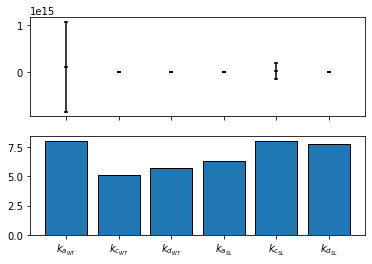

In [11]:
fig, ax = plt.subplots(2, sharex = True)
x = np.linspace(1, 6, len(means))

ax[0].scatter(x,
           means,
           marker = '_',
           s = 20,
           color = 'black')
for i in range(len(stdevs)):
    ax[0].plot([x[i], x[i]],
               [means[i] - stdevs[i], means[i] + stdevs[i]],
               color = 'black')
    ax[0].scatter([x[i], x[i]],
                  [means[i] - stdevs[i], means[i] + stdevs[i]],
                  marker = '_',
                  s = 10,
                 color = 'black')
    #ax[0].scatter([x[i]] * len(param_vals[:,i]),
    #              param_vals[:, i],
    #              marker = 'O',
    #              s = 2,
    #              edgecolor = 'black',
    #              color = (0,0,0,0))
    
ax[1].bar(x,
          np.array(stdevs)/np.array(means),
          linewidth = 1,
         edgecolor = 'black')

ax[1].set_xticks(x, labels = xlabels)

plt.show()

In [12]:
#scale each param by group mean
param_scaled = []
for i in range(len(means)):
    param_scaled.append(param_vals[:, i] / means[i])

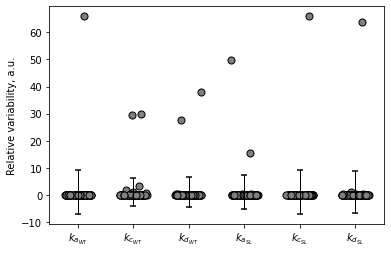

In [13]:
fig, ax = plt.subplots()

w = 0.5

for i in range(len(x)):
    mn = np.mean(param_scaled[i][~np.isnan(param_scaled[i])])
    std = np.std(param_scaled[i][~np.isnan(param_scaled[i])])
    ax.scatter(x[i] + np.random.random(param_scaled[i].size) * w - w/2,
               param_scaled[i],
               marker = 'o',
               edgecolor = 'black',
               linewidth = 1,
               s = 50,
               c = '#808080')
    ax.plot([x[i], x[i]],
            [mn - std, mn + std],
            linewidth = 1,
            color = 'black')
    ax.scatter(x[i],
               mn,
               marker = '_',
               s = 55,
               c = 'black')
    ax.scatter([x[i], x[i]],
               [mn - std, mn + std],
               marker = '_',
               s = 45,
               c = 'black')
    
    
ax.set_xticks(x, labels = xlabels)
ax.set_ylabel('Relative variability, a.u.')
#ax.set_yscale('log')

plt.savefig('relative_var_params.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [14]:
#filter outliers above 0.15
param_scaled_filtered = param_scaled
filtered = [0] * len(param_scaled_filtered)
for i in range(len(param_scaled_filtered)):
    for j in range(len(param_scaled_filtered[i])):
        if param_scaled_filtered[i][j] >= 0.15:
            param_scaled_filtered[i][j] = np.nan
            filtered[i] += 1

In [15]:
filtered

[1, 7, 4, 4, 1, 5]

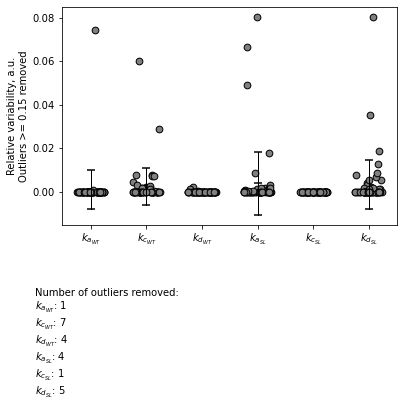

In [16]:
fig, ax = plt.subplots()

w = 0.5

for i in range(len(x)):
    mn = np.mean(param_scaled_filtered[i][~np.isnan(param_scaled_filtered[i])])
    std = np.std(param_scaled_filtered[i][~np.isnan(param_scaled_filtered[i])])
    ax.plot([x[i], x[i]],
            [mn - std, mn + std],
            linewidth = 1,
            color = 'black')
    ax.scatter(x[i],
               mn,
               marker = '_',
               s = 50,
               c = 'black')
    ax.scatter([x[i], x[i]],
               [mn - std, mn + std],
               marker = '_',
               s = 55,
               c = 'black')
    ax.scatter(x[i] + np.random.random(param_scaled_filtered[i].size) * w - w/2,
               param_scaled_filtered[i],
               marker = 'o',
               edgecolor = 'black',
               linewidth = 1,
               s = 45,
               c = '#808080')
    
ax.set_xticks(x, labels = xlabels)
ax.set_ylabel('Relative variability, a.u.\nOutliers >= 0.15 removed')

outliers_removed = 'Number of outliers removed:\n'
for i in range(len(filtered)):
    outliers_removed += f'{xlabels[i]}: {filtered[i]}\n'
ax.text(0, -.1, outliers_removed)

plt.savefig('relative_var_params_outliers-removed.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

## Stats

In [20]:
import scipy.stats as st
import scikit_posthocs as sp

In [39]:
#scale each param by group mean again
##filtering messes up variable names...
param_scaled = []
for i in range(len(means)):
    param_scaled.append(param_vals[:, i] / means[i])

In [40]:
##Normality, equal variance assumed
stat, p = st.f_oneway(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])])
print(f'stat = {stat}, p = {p}')

stat = 4.672915989989077e-32, p = 1.0


In [41]:
out = st.tukey_hsd(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],)


In [42]:
out.statistic

array([[ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,
        -2.22044605e-16, -2.22044605e-16],
       [ 0.00000000e+00,  0.00000000e+00, -2.22044605e-16,
        -2.22044605e-16, -2.22044605e-16],
       [ 2.22044605e-16,  2.22044605e-16,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.22044605e-16,  2.22044605e-16,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.22044605e-16,  2.22044605e-16,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [43]:
out.pvalue

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [44]:
#Normality testing
for i in range(len(param_scaled)):
    stat, p = st.shapiro(param_scaled[i][~np.isnan(param_scaled[i])])
    
    print(f'{xlabels[i]}: stat = {stat}, p = {p}')

$k_{a_{WT}}$: stat = 0.10268789529800415, p = 4.309365318759346e-18
$k_{c_{WT}}$: stat = 0.19134914875030518, p = 2.991587028187445e-17
$k_{d_{WT}}$: stat = 0.1685882806777954, p = 1.792733652335151e-17
$k_{a_{SL}}$: stat = 0.14793741703033447, p = 1.1367398046292587e-17
$k_{c_{SL}}$: stat = 0.10250413417816162, p = 4.292762563094488e-18
$k_{d_{SL}}$: stat = 0.10711371898651123, p = 4.730424652376907e-18


In [45]:
##Not normal! Kruskal-Wallis
stat, p = st.kruskal(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])])

print(f'stat = {stat}, p = {p}')

stat = 206.05378030360885, p = 1.4390879773035226e-42


In [46]:
#Dunn's post-hoc
sp.posthoc_dunn([param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])]], p_adjust = 'bonferroni')

,1,2,3,4,5,6
1,1.000000e+00,1.603284e-19,1.378249e-07,3.824562e-11,1.000000e+00,1.848786e-23
2,1.603284e-19,1.000000e+00,5.077146e-03,2.983272e-01,1.076571e-20,1.000000e+00
3,1.378249e-07,5.077146e-03,1.000000e+00,1.000000e+00,2.502523e-08,1.014511e-04
4,3.824562e-11,2.983272e-01,1.000000e+00,1.000000e+00,4.909360e-12,1.758502e-02
5,1.000000e+00,1.076571e-20,2.502523e-08,4.909360e-12,1.000000e+00,9.607998e-25
6,1.848786e-23,1.000000e+00,1.014511e-04,1.758502e-02,9.607998e-25,1.000000e+00


In [47]:
#re-run with filtered data
filtered = [0] * len(param_scaled)
for i in range(len(param_scaled)):
    for j in range(len(param_scaled[i])):
        if param_scaled[i][j] >= 0.15:
            param_scaled[i][j] = np.nan
            filtered[i] += 1
filtered

[1, 7, 4, 4, 1, 5]

In [48]:
##Normality, equal variance assumed
stat, p = st.f_oneway(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])])
print(f'stat = {stat}, p = {p}')

stat = 2.046741243446669, p = 0.07149972581055818


In [49]:
out = st.tukey_hsd(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],)


In [50]:
out.statistic

array([[ 0.00000000e+00, -1.24127508e-03,  1.08103721e-03,
        -2.71013469e-03,  1.14997483e-03],
       [ 1.24127508e-03,  0.00000000e+00,  2.32231229e-03,
        -1.46885962e-03,  2.39124990e-03],
       [-1.08103721e-03, -2.32231229e-03,  0.00000000e+00,
        -3.79117191e-03,  6.89376162e-05],
       [ 2.71013469e-03,  1.46885962e-03,  3.79117191e-03,
         0.00000000e+00,  3.86010952e-03],
       [-1.14997483e-03, -2.39124990e-03, -6.89376162e-05,
        -3.86010952e-03,  0.00000000e+00]])

In [51]:
out.pvalue

array([[1.        , 0.92820952, 0.95358812, 0.38369575, 0.93989316],
       [0.92820952, 1.        , 0.56739394, 0.8791293 , 0.52714423],
       [0.95358812, 0.56739394, 1.        , 0.10041016, 0.99999903],
       [0.38369575, 0.8791293 , 0.10041016, 1.        , 0.08384873],
       [0.93989316, 0.52714423, 0.99999903, 0.08384873, 1.        ]])

In [52]:
#Normality testing
for i in range(len(param_scaled)):
    stat, p = st.shapiro(param_scaled[i][~np.isnan(param_scaled[i])])
    
    print(f'{xlabels[i]}: stat = {stat}, p = {p}')

$k_{a_{WT}}$: stat = 0.10507816076278687, p = 6.098174412678239e-18
$k_{c_{WT}}$: stat = 0.29415255784988403, p = 2.5412822243959816e-15
$k_{d_{WT}}$: stat = 0.20357120037078857, p = 1.264394667728464e-16
$k_{a_{SL}}$: stat = 0.2912956476211548, p = 9.956269842790566e-16
$k_{c_{SL}}$: stat = 0.1036602258682251, p = 5.919642366709694e-18
$k_{d_{SL}}$: stat = 0.31174588203430176, p = 2.1976619217603565e-15


In [53]:
##Not normal! Kruskal-Wallis
stat, p = st.kruskal(param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])])

print(f'stat = {stat}, p = {p}')

stat = 208.85188964831423, p = 3.623998884315573e-43


In [54]:
#Dunn's post-hoc
sp.posthoc_dunn([param_scaled[0][~np.isnan(param_scaled[0])],
                     param_scaled[1][~np.isnan(param_scaled[1])],
                     param_scaled[2][~np.isnan(param_scaled[2])],
                     param_scaled[3][~np.isnan(param_scaled[3])],
                     param_scaled[4][~np.isnan(param_scaled[4])],
                     param_scaled[5][~np.isnan(param_scaled[5])]], p_adjust = 'bonferroni')

,1,2,3,4,5,6
1,1.000000e+00,9.023919e-19,3.032954e-07,3.975230e-11,1.000000e+00,1.821684e-24
2,9.023919e-19,1.000000e+00,5.463329e-03,4.035994e-01,5.675225e-20,1.000000e+00
3,3.032954e-07,5.463329e-03,1.000000e+00,1.000000e+00,5.184242e-08,2.101298e-05
4,3.975230e-11,4.035994e-01,1.000000e+00,1.000000e+00,4.535560e-12,8.057191e-03
5,1.000000e+00,5.675225e-20,5.184242e-08,4.535560e-12,1.000000e+00,7.574393e-26
6,1.821684e-24,1.000000e+00,2.101298e-05,8.057191e-03,7.574393e-26,1.000000e+00
